In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import aux
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

- This notebook contains the code to reproduce the analysis and plotting for the fourth figure, using the companion dataset (which gives summary statistics for all plastic spiking networks simulated on the ISTA cluster)  
  
- Each section below can be run independently

### Histogram of all plasticty rules simulated (Fig4.A)

In [36]:
# load all the rule quartets we simulated at least once in the familiarity/novelty task
save_dir = "../data/"
data = aux.load_and_merge(save_dir,("2850_1s4hBreaks_15082024_metrics.npy",
                        "1k_mfnpe_rexc_1s4hBreaks_16022025_metrics.npy",
                        "1k_mfnpe_rexcwblow_1s4hBreaks_18022025_metrics.npy",
                        "1k_1s4hBreaks_mfnpe_dr0p2_25022025_metrics.npy",
                        "1k_1s4hBreaks_mfnpe_dr0_25022025_metrics.npy",
                        "1k_1s4hBreaks_mfnpe_drm0p2_25022025_metrics.npy",
                        "1k_BND_mf_npe_ONnov1p5_040325_metrics.npy"))

inds_stable = aux.get_ind_stable(data)
d = data[inds_stable]

retrieved 8850/8850 simulations
8760 / 8850 rules fulfill the rate condition 98.98305084745763 %
8538 / 8850 rules fulfill the cv condition 96.47457627118644 %
6666 / 8850 rules fulfill the wf condition 75.32203389830508 %
7326 / 8850 rules fulfill the w_blow condition 82.77966101694916 %
5850 / 8850 rules fulfill all conditions 66.10169491525424 %


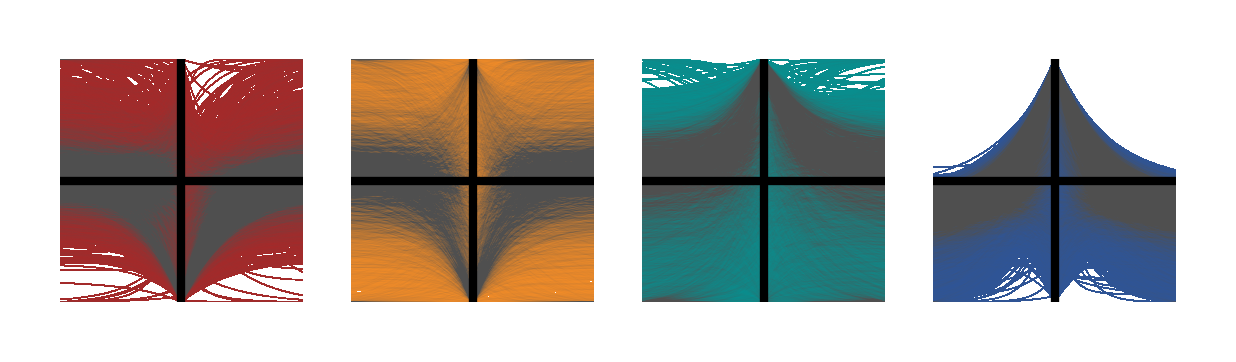

In [37]:
# compute the histogram of dw for each rule 
n_timebins = 1000; n_dwbins=1000
dws_ee, dws_ei, dws_ie, dws_ii, dws_hist_norm_ee, dws_hist_norm_ei, dws_hist_norm_ie, dws_hist_norm_ii = aux.get_shape_histogram(d['theta'][:,:-1], n_timebins=n_timebins, n_dwbins=n_dwbins)
# plot the histogram of dw for all rules in the dataset
aux.plot_4_rules_histogram(dws_hist_norm_ee,
                        dws_hist_norm_ei,
                        dws_hist_norm_ie,
                        dws_hist_norm_ii,
                        cmap_list = [aux.cmap_ee, aux.cmap_ei, aux.cmap_ie, aux.cmap_ii],
                        cap=10,
                        figsize=(2.4,0.6),
                        linewidth=1)

### Dimensionality reduction in plasticity parameter space and function space (Fig4.B)

In [38]:
# Load the 2500 quartets for which we have several trials on all tasks
save_dir = "../data/"
seq1 = aux.load_and_merge(save_dir,("2500_seq_1s4hBreaks_07112024_metrics.npy",))
seq2 = aux.load_and_merge(save_dir,("2500_seq_1s4hBreaks_10112024_metrics.npy",))
seq_list = [seq1, seq2]

bnd1 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_19082024_metrics.npy",))
bnd2 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_20082024_metrics.npy",))
bnd3 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_17092024_metrics.npy",))
bnd4 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_22092024_metrics.npy",))
bnd5 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_24092024_metrics.npy",))
bnd_list = [bnd1, bnd2, bnd3, bnd4, bnd5]

retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations


In [39]:
# Compute all task metric for these 2500 rules
# Novelty/familiarity
dr = np.array([2*(d['r_nov'] - d['r_fam']) / (d['r_nov'] + d['r_fam']+0.01) for d in bnd_list])
dr_10s = np.mean(dr[:,:,1], axis=0)
np.nan_to_num(dr_10s, copy=False, nan=0.0) 
dr_4h = np.mean(dr[:,:,-1], axis=0)
np.nan_to_num(dr_4h, copy=False, nan=0.0)

# Transient dynamics
on_nov = np.nanmean( [np.max(d['prate'][:,:,10:20], axis=2)/(np.nanmean(d['prate'][:,:,10:20], axis=2)+0.01) for d in bnd_list], axis=0 )
on_nov_4h = on_nov[:,-1]
np.nan_to_num(on_nov_4h, copy=False, nan=1.0)
on_fam = np.nanmean( [np.max(d['prate'][:,:,50:60], axis=2)/(np.nanmean(d['prate'][:,:,50:60], axis=2)+0.01) for d in bnd_list], axis=0 )
DeltaON_10s = 2*(on_nov[:,1]-on_fam[:,1])/(on_nov[:,1]+on_fam[:,1])
np.nan_to_num(DeltaON_10s, copy=False, nan=0.0)
DeltaON_4h = 2*(on_nov[:,-1]-on_fam[:,-1])/(on_nov[:,-1]+on_fam[:,-1])
np.nan_to_num(DeltaON_4h, copy=False, nan=0.0)

# Sequential task metrics
n_fam = 5
n_tot = 7
n_nov = 2
n_rules = seq1['eng_rate'].shape[0]
n_tests = seq1['eng_rate'].shape[1]
n_engs = seq1['eng_rate'].shape[2]
n_bins = seq1['eng_rate'].shape[3]
ontime_test = 2 #in number of bins. usually bin is 0.1s
offtime_test = 28 #in number of bins. usually bin is 0.1s
test_starts = 10 #in number of bins, how long do we record pretest (usually 1s)
t_breaks = [1, 9,  10, 40, 60,  180, 300, 600,  2400, 10800]
succ = np.array([aux.compute_succ(eng_rate=seq['eng_rate'], n_tot=n_tot, n_bins=n_bins, 
                                  test_starts=test_starts, ontime_test=ontime_test,
                                  offtime_test=offtime_test,n_rules=n_rules, n_tests=n_tests,
                                  n_fam=n_fam, n_engs=n_engs, method='both',
                                  raw_r_rest=seq['non_eng_rate'], raw_r_pop=seq['prate']) for seq in seq_list])
succ = np.mean(succ, axis=4)
mp1_10s = np.mean(succ[:,:,1,3], axis=0)
np.nan_to_num(mp1_10s, copy=False, nan=1.0)
mp1_4h = np.mean(succ[:,:,-1,3], axis=0)
np.nan_to_num(mp1_4h, copy=False, nan=1.0)

aux_big_array = np.array([aux.get_dr_stfam(n_bins=n_bins, test_starts=test_starts, ontime_test=ontime_test, offtime_test=offtime_test, rpop=seq['prate'],n_fam=n_fam,n_nov=n_nov) for seq in seq_list])
dr_famnov_list = aux_big_array[:,0,:,:]
dr_novnov_list = aux_big_array[:,1,:,:]

famnov_10s = np.mean(dr_famnov_list[:,:,1], axis=0)
np.nan_to_num(famnov_10s, copy=False, nan=1.0)

famnov_4h = np.mean(dr_famnov_list[:,:,-1], axis=0)
np.nan_to_num(famnov_4h, copy=False, nan=1.0)

novnov_10s = np.mean(dr_novnov_list[:,:,1], axis=0)
np.nan_to_num(novnov_10s, copy=False, nan=1.0)

novnov_4h = np.mean(dr_novnov_list[:,:,-1], axis=0)
np.nan_to_num(novnov_4h, copy=False, nan=1.0)

/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_30483/2435652768.py:10: RuntimeWarning: Mean of empty slice
  on_nov = np.nanmean( [np.max(d['prate'][:,:,10:20], axis=2)/(np.nanmean(d['prate'][:,:,10:20], axis=2)+0.01) for d in bnd_list], axis=0 )
/var/folders/fg/6y_rzvdn0_s9tr1lxxw5r9p40000gn/T/ipykernel_30483/2435652768.py:13: RuntimeWarning: Mean of empty slice
  on_fam = np.nanmean( [np.max(d['prate'][:,:,50:60], axis=2)/(np.nanmean(d['prate'][:,:,50:60], axis=2)+0.01) for d in bnd_list], axis=0 )


array([-0.00620233, -0.01203705, -0.00319952, ..., -0.02676981,
       -0.01465714, -0.0115986 ])

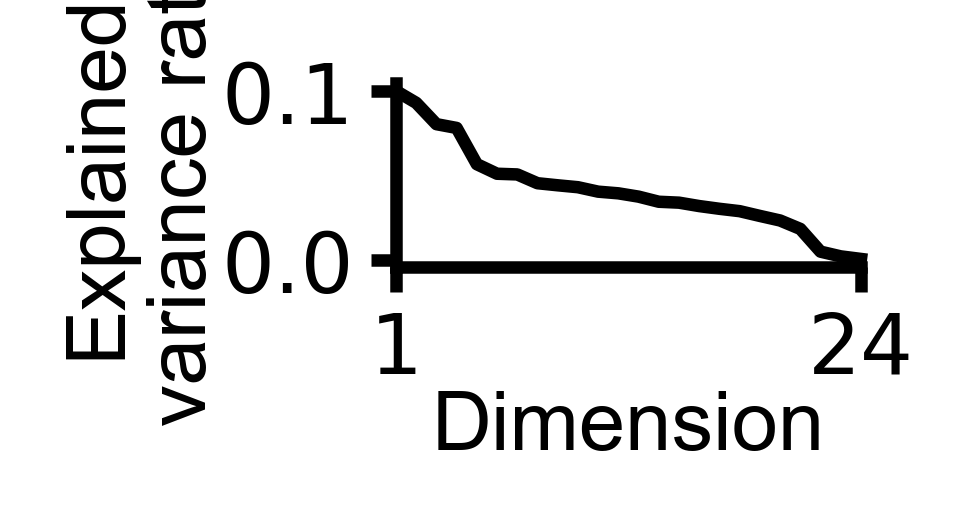

In [40]:
# Dimensionality reduction in pladticity parameter space
# PCA
X = bnd1['theta'][:,:-1]
n_samples = X.shape[0]
n_features = X.shape[1]
X = (X-np.mean(X, axis=0))/np.std(X, axis=0) #zscore and not whiten

pca = PCA(whiten=False)
pca.fit(X)

Xt = pca.transform(X)

aux.plot_fraction_significant_rules(pca.explained_variance_ratio_,
                                    x_lim=[0,23],
                                    x_ticks=[0,23],
                                    x_ticklabels=['1', '24'],
                                    y_ticks=[0,0.1],
                                    x_label='Dimension',
                                    y_label="Explained\nvariance ratio",
                                    xticks_pad=2,
                                    yticks_pad=2,
                                    labelpad_ylabel=0,
                                    labelpad_xlabel=0,
                                    figsize=(1,0.4))

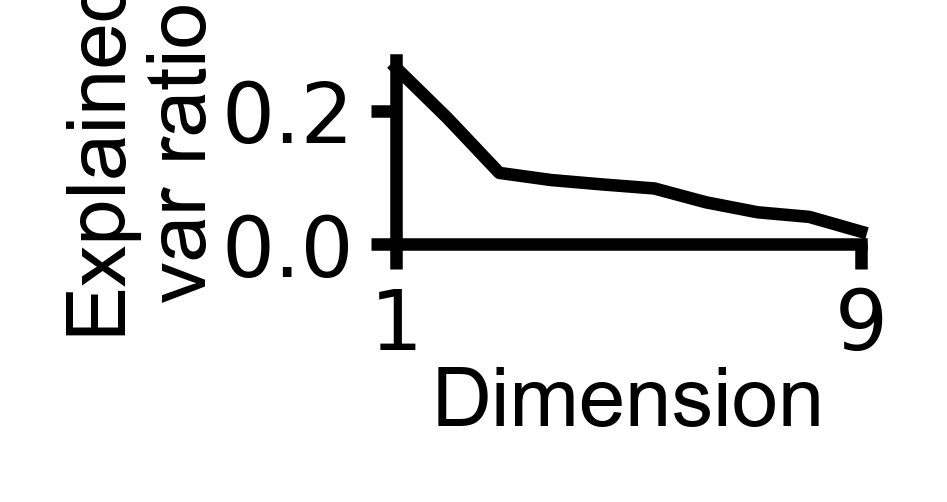

In [41]:
# Dimensionality reduction in network function space
X = np.array([dr_10s, dr_4h, DeltaON_10s, DeltaON_4h, mp1_10s, mp1_4h, famnov_10s, famnov_4h, novnov_10s, novnov_4h])
n_samples = X.shape[1]
n_features = X.shape[0]
X = X.T
X = (X-np.mean(X, axis=0))/np.std(X, axis=0) #zscore and not whiten

# PCA
pca = PCA(whiten=False)
pca.fit(X)
Xt = pca.transform(X)

# plot variance explained
aux.plot_fraction_significant_rules(pca.explained_variance_ratio_,
                                    x_lim=[0,9],
                                    x_ticks=[0,9],
                                    x_ticklabels=['1', '9'],
                                    y_ticks=[0,0.2],
                                    x_label='Dimension',
                                    y_label="Explained\nvar ratio",
                                    xticks_pad=2,
                                    yticks_pad=2,
                                    labelpad_ylabel=0,
                                    labelpad_xlabel=0,
                                    figsize=(1,0.4))

### Visualization of plasticity parameter space (Fig4.C)

#### Analysis of stored simulations

In [42]:
# Load simulations: each rule was sampled along the slice in plasticity parameter space
datac = pd.read_csv("../data/DPR_combined_metrics_ths_grid_center_4.csv")
n_rules = len(datac)

# Apply the function to the 'thetas' column
fields = ['thetas', 'rate', 'cv_isi', 'weef', 'weif', 'wief', 'wiif', 'w_blow', 'w_creep', 'r_fam', 'r_nov', 'r_mem']
for field in fields:
    datac[field] = datac[field].apply(aux.string_to_float_list)

In [43]:
# compute the network function on the familiarity task for all these simulated rules
dr = np.zeros( (n_rules, 10) )
for ind_num in range(len(datac)):
    dr[ind_num] = [2*(datac['r_nov'][ind_num][i] - datac['r_fam'][ind_num][i]) / (datac['r_nov'][ind_num][i] + datac['r_fam'][ind_num][i]+0.01) for i in range(10)]

# compute stability
inds_stable = aux.get_ind_stable_pd(datac)

rates 1134 / 1260
cv_isi 668 / 1260
weef 935 / 1260
weif 632 / 1260
wief 576 / 1260
wiif 295 / 1260
w_blow 188 / 1260
72 / 1260 rules fulfill all conditions 5.714285714285714 %


Angle of rotation 236.2663737180521


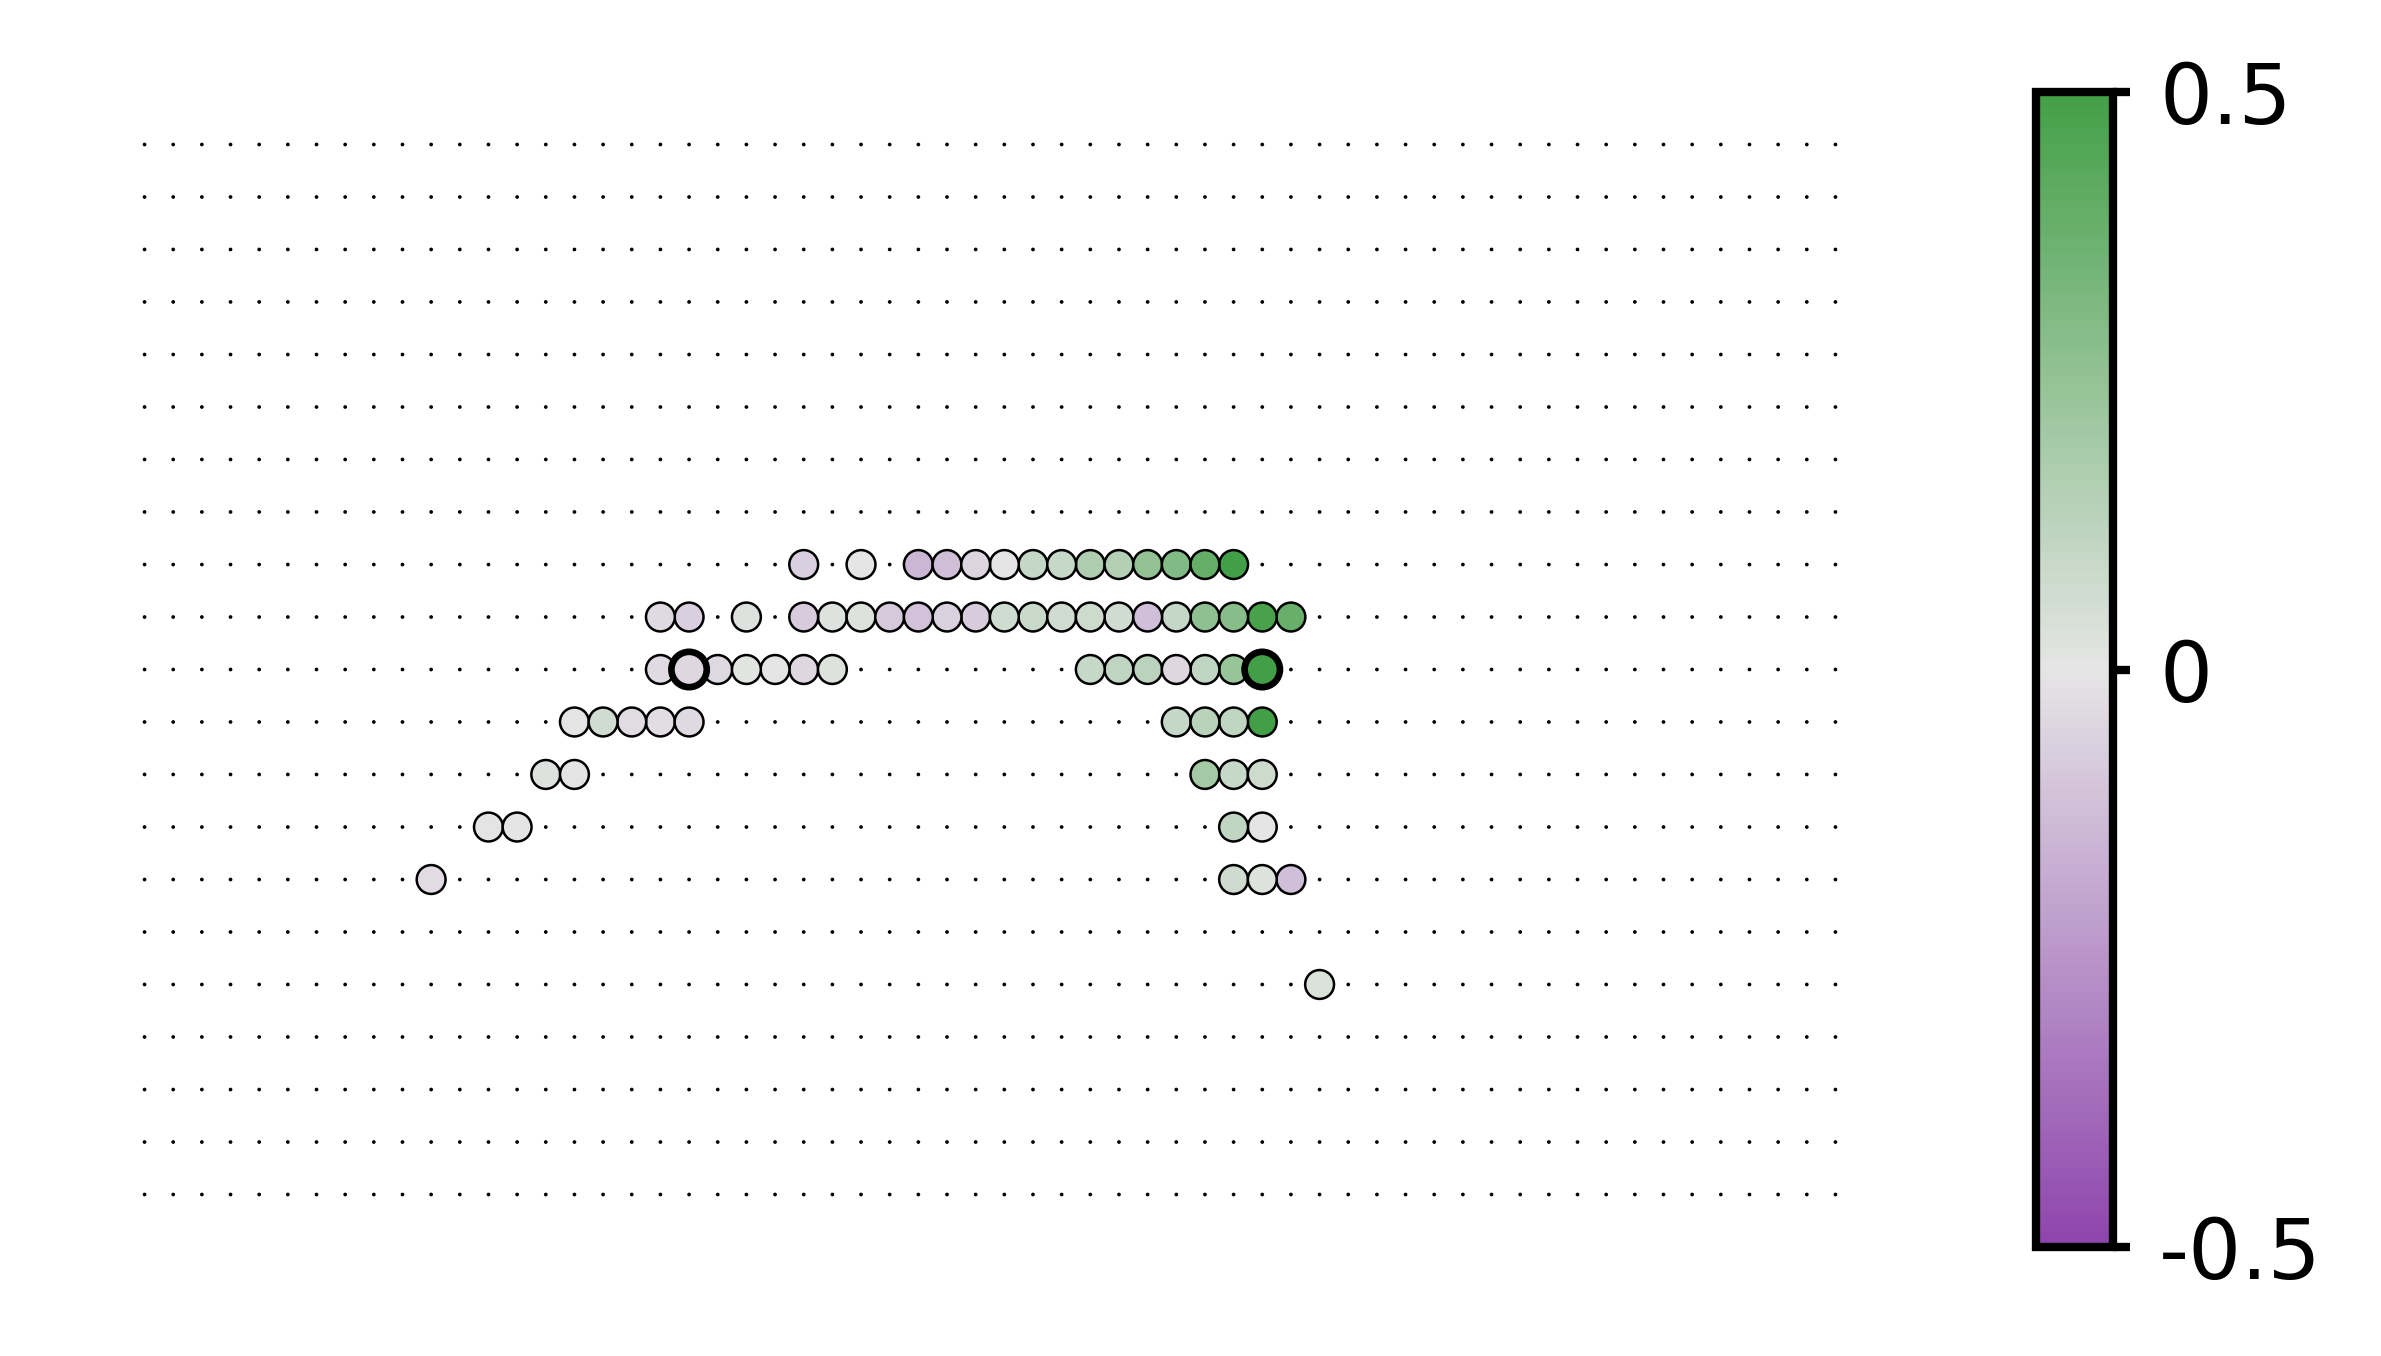

In [44]:
# plot the rules witht their network function and stability
alphas_EE = np.zeros(n_rules)
betas_EE = np.zeros(n_rules)
dr_10min = np.zeros(n_rules)

for i in range(n_rules):
    alphas_EE[i] = datac['thetas'][i][2]
    betas_EE[i] = datac['thetas'][i][3]
    dr_10min[i] = dr[i,6]

x = alphas_EE
y = betas_EE

# Find the point with the smallest x value
ind_sortx = np.argsort(x)
x_sorted = x[ind_sortx]
x0 = x_sorted[0]
y0 = y[ind_sortx][0]
x1 = x_sorted[1]
y1 = y[ind_sortx][1]
angle = np.arctan2(x1 - x0, y1 - y0) + np.pi/2
print("Angle of rotation", angle*180/np.pi)

# Create the rotation matrix
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])

# Stack the transformed_alphas and transformed_betas into a 2xN array
points = np.vstack((x, y))

# Apply the rotation matrix
rotated_points1 = np.dot(rotation_matrix, points)
rotated_x1 = rotated_points1[0, :]
rotated_y1 = rotated_points1[1, :]

# Somehow the x axis is not aligned, correct accordingly
rotated_y1 = np.round(rotated_y1, 4)
new_rotated_x1 = np.zeros_like(rotated_x1)
ind_ys = np.argwhere(rotated_y1 == np.min(rotated_y1)).flatten()
ind_xs = np.argsort(rotated_x1[ind_ys])
xs_ref = rotated_x1[ind_ys][ind_xs]
for y_unique in np.unique(rotated_y1):
    ind_ys = np.argwhere(rotated_y1 == y_unique).flatten()
    ind_xs = np.argsort(rotated_x1[ind_ys])
    for i in range(len(rotated_x1[ind_ys][ind_xs])):
        new_rotated_x1[ind_ys[ind_xs][i]] = xs_ref[i]

xt = new_rotated_x1
yt = rotated_y1

n_uniquex = len(np.unique(xt))
n_uniquey = len(np.unique(yt))

# find the indices of the two stable rules from which the slice was generated
row_index = datac[datac['thetas'].apply(lambda x: x[0] == 0.03947454)].index
row_index2 = datac[datac['thetas'].apply(lambda x: x[0] == 0.0424992554)].index
ind_rules_base = [row_index[0], row_index2[0]] # should be [935,1107]

aux.plot_rotated_points(xt,yt, dr_10min, inds_stable, figsize=(5,2.5), xticks=[], yticks=[], inds_rules_base=ind_rules_base,
                    marker_unstable='o', edgecolors_unstable = 'none', marker_size_unstable=0.2, facecolor_unstable='black', linewidths_unstable=0.0,
                    marker_stable='o', edgecolors_stable = 'black', marker_size_stable=12, facecolor_stable='none', linewidths_stable=0.3,
                    marker_base='o', edgecolors_base = 'black', marker_size_base=18, facecolor_base='black', linewidths_base=0.8,
                    linewidth=1, cbarticks=[-0.5, 0 ,0.5], cbarticklabels=[-0.5, 0 ,0.5], vmin=-0.5, vmax=0.5,)

#### How the simulated rule quartets above were generated

retrieved 2500/2500 simulations
Generating random orthogonal direction: before [ 0.04370861  0.09556429  0.92797577  0.39463394 -1.37592544 -1.37602192
  0.01522753  0.08795585  0.40446005  0.83229031 -1.91766202  1.87963941
  0.08491984  0.02911052 -1.27270013 -1.26638196 -0.78303103  0.09902573
  0.04887505  0.03621062  0.44741158 -1.44202456 -0.83142141 -0.53455263] overlap -3.9588376108024206 after [ 0.04320867  0.09678847  1.06747291  0.1857325  -1.17695597 -1.4656747
  0.01303314  0.09488219  0.35403338  0.8620229  -1.97297256  1.74822421
  0.08717248  0.02313402 -1.40634899 -1.07134968 -0.88101839 -0.38383404
  0.0464693   0.03917529  0.26555428 -1.30967809 -0.96791279 -0.14483522] overlap 1.3322676295501878e-15
Steps: x [-0.00015124  0.00037032  0.04219851 -0.06319362  0.06018915 -0.02712037
 -0.00066381  0.00209525 -0.01525429  0.00899424 -0.01673169 -0.03975369
  0.00068143 -0.00180792 -0.04042938  0.05899814 -0.02964162 -0.14606724
 -0.00072775  0.00089682 -0.05501265  0.040

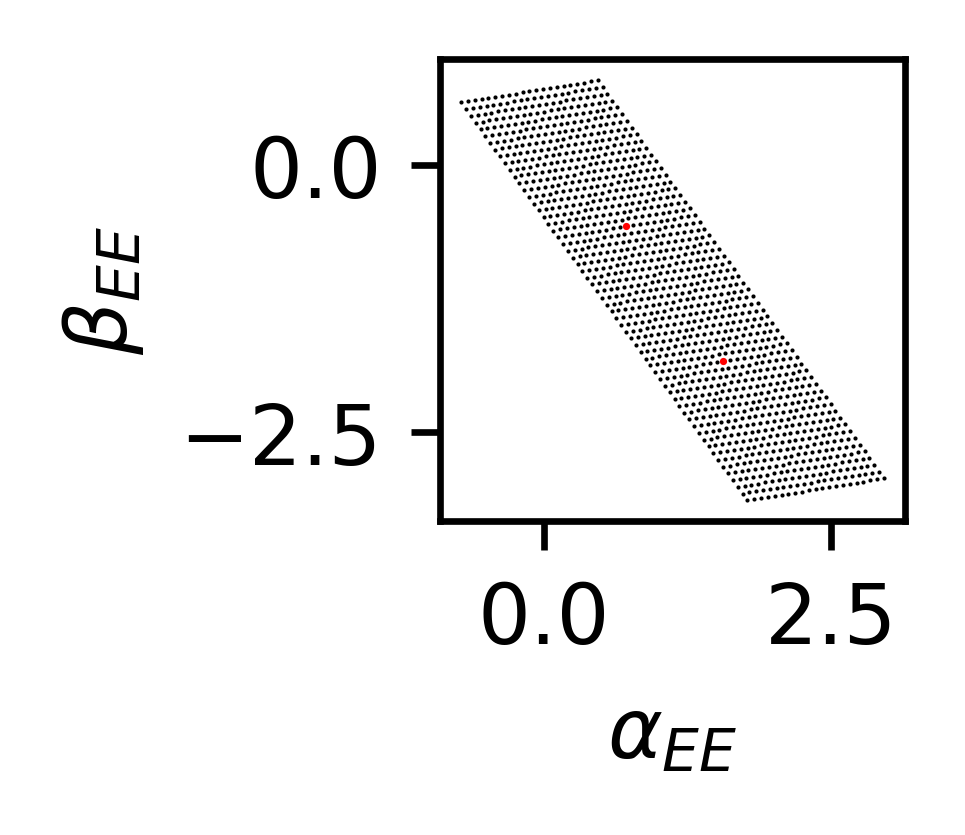

plot taus along this grid


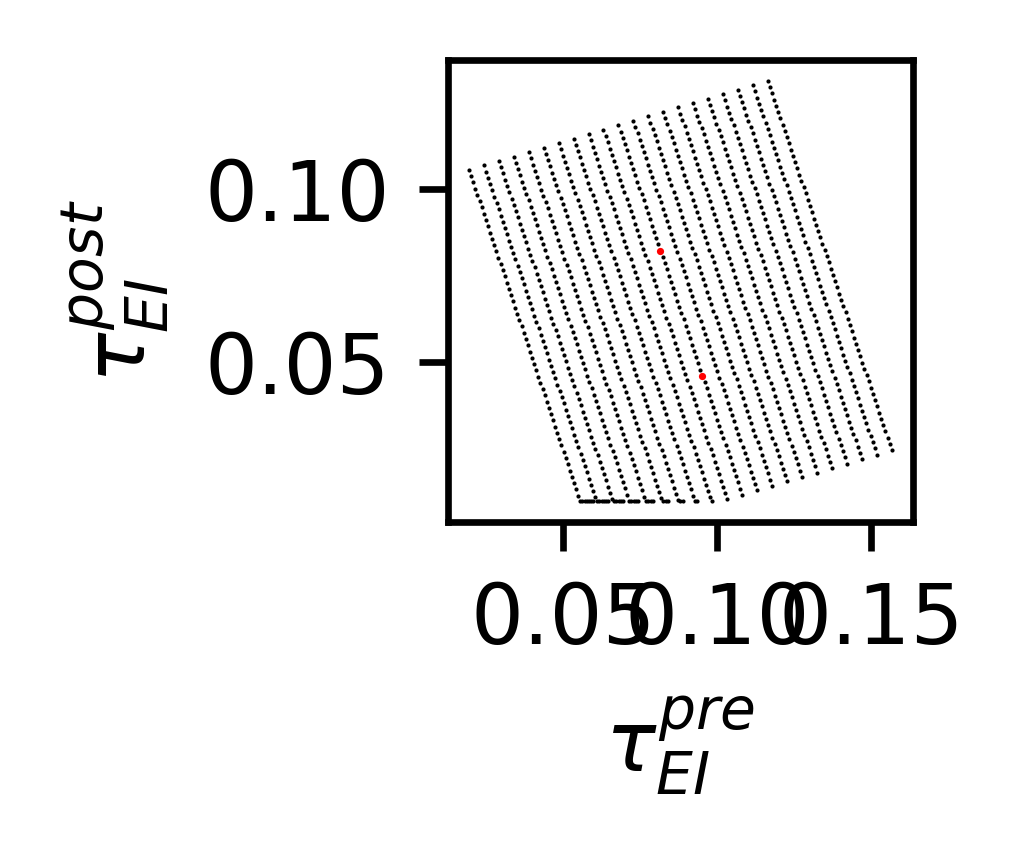

In [45]:
# Generate interpolations of rules within a plane for postman's problem
d1 = aux.load_and_merge("../data/",("2500_1s4hBreaks_19082024_metrics.npy",))

# the two rule quartets we want to interpolated between
th1 = d1['theta'][656][:-1] #exclude input rate (last element)
th2 = d1['theta'][2385][:-1]

Dth = th2 - th1
np.random.seed(seed=42)
lowb = [0.01, 0.01, -2., -2., -2., -2., 0.01, 0.01, -2., -2., -2., -2., 0.01, 0.01, -2., -2., -2., -2., 0.01, 0.01, -2., -2., -2., -2.] # how I had initially sampled my rules
upb = [.1, .1, 2., 2., 2., 2., .1, .1, 2., 2., 2., 2., .1, .1, 2., 2., 2., 2., .1, .1, 2., 2., 2., 2.]
th_rand = np.random.uniform(low=lowb, high=upb, size=24)  # generate a random vector that respects the scale differences between timescales and normal parameters
th_orth = th_rand - np.dot(Dth, th_rand)/np.dot(Dth, Dth)*Dth # remove overlap with Dth, = orthogonalize
print("Generating random orthogonal direction: before", th_rand, "overlap", np.dot(Dth, th_rand), "after", th_orth, "overlap", np.dot(Dth, th_orth))

n_samples_interp = 20 #how many points we sample between theta1 and theta2, that step vector will serve as the unit for all perturbations
x_step = Dth/n_samples_interp
y_step = th_orth/np.linalg.norm(th_orth)*np.linalg.norm(x_step) #that orthogonal step should have the same norm as the x step
print("Steps: x", x_step, np.linalg.norm(x_step), "y", y_step, np.linalg.norm(y_step))

n_x_steps_outside = 20
n_y_steps = 21 #odd for symmetry
Ths_grid = np.zeros(((n_x_steps_outside*2 + n_samples_interp)*n_y_steps, 24)) # all our thetas on the plane
origin_theta = th1 - n_x_steps_outside*x_step - n_y_steps//2*y_step
count = 0
for x_pert_num in range(n_x_steps_outside*2 + n_samples_interp):
    for y_pert_num in range(n_y_steps):
        Ths_grid[count,:] = origin_theta + x_pert_num*x_step + y_pert_num*y_step
        count += 1

for i in [0,1,6,7,12,13,18,19]: #indices of tau parameters
    Ths_grid[:,i][Ths_grid[:,i] < 0.01] = 0.01 #make all timescales > 10ms at the end, otherwise unpredictable auryn behavior

# Check all has worked:
print("plot two normal parameters along this grid, red are the two rules from the manifold")
plt.figure(figsize=(1,1), dpi=600)
plt.scatter(Ths_grid[:,2], Ths_grid[:,3], marker='.', s=1, color='black', edgecolor='white', linewidth=0)
plt.scatter([th1[2], th2[2]], [th1[3], th2[3]], marker='.', s=3, color='red', edgecolor='white', linewidth=0)
plt.xlabel(r'$\alpha_{EE}$')
plt.ylabel(r'$\beta_{EE}$')
plt.show()

print("plot taus along this grid")
plt.figure(figsize=(1,1), dpi=600)
plt.scatter(Ths_grid[:,12], Ths_grid[:,13], marker='.', s=1, color='black', edgecolor='white', linewidth=0)
plt.scatter([th1[12], th2[12]], [th1[13], th2[13]], marker='.', s=3, color='red', edgecolor='white', linewidth=0)
plt.xlabel(r'$\tau^{pre}_{EI}$')
plt.ylabel(r'$\tau^{post}_{EI}$')
plt.show()

### KOs analysis (Fig4.D)

#### Triple KOs, single-active rule

In [46]:
# load the data of the summary statics of network with triple KOs
df = pd.read_csv("../data/combined_metrics_triple_ko_4h.csv")
fields = ['thetas', 'rate', 'cv_isi', 'weef', 'weif', 'wief',
          'wiif', 'w_blow', 'w_creep', 'r_fam', 'r_nov']
for field in fields:
    df[field] = df[field].apply(aux.string_to_float_list)

In [47]:
# find which of these simulations are stable
inds_stable = aux.get_ind_stable_pd(df)

rates 11620 / 12500
cv_isi 10974 / 12500
weef 11136 / 12500
weif 11117 / 12500
wief 9972 / 12500
wiif 12157 / 12500
w_blow 7717 / 12500
5533 / 12500 rules fulfill all conditions 44.263999999999996 %


In [48]:
num_stable_ie = np.sum(inds_stable[:2500])
num_stable_ee = np.sum(inds_stable[2500:5000])
num_stable_ctrl = np.sum(inds_stable[5000:7500])
num_stable_ei = np.sum(inds_stable[7500:10000])
num_stable_ii = np.sum(inds_stable[10000:12500])
print(num_stable_ctrl, "stable ctrl sims. % of unstable sims:", 100 - num_stable_ctrl/2500*100,"%")
print(num_stable_ee, "stable ee sims. % of unstable sims:", 100 -  num_stable_ee/2500*100,"%")
print(num_stable_ei, "stable ei sims. % of unstable sims:", 100 - num_stable_ei/2500*100,"%")
print(num_stable_ie, "stable ie sims. % of unstable sims:", 100 - num_stable_ie/2500*100,"%")
print(num_stable_ii, "stable ii sims. % of unstable sims:", 100 -  num_stable_ii/2500*100,"%")

2449 stable ctrl sims. % of unstable sims: 2.039999999999992 %
2350 stable ee sims. % of unstable sims: 6.0 %
105 stable ei sims. % of unstable sims: 95.8 %
95 stable ie sims. % of unstable sims: 96.2 %
534 stable ii sims. % of unstable sims: 78.64 %


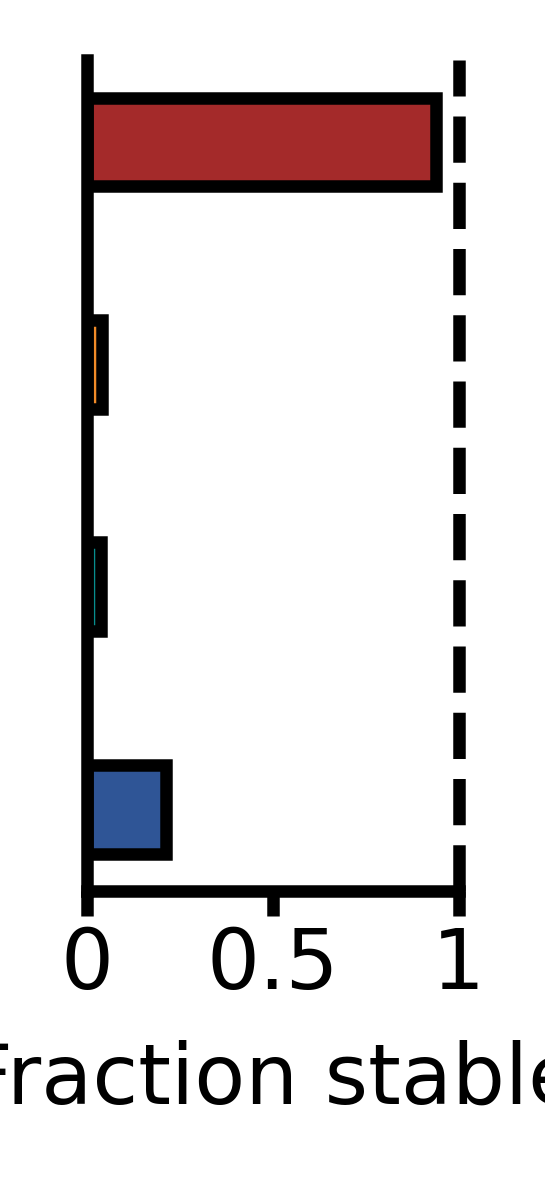

In [49]:
# plot the fraction of stable simulations for each KO condition
frac_ee = num_stable_ee/2500
frac_ei = num_stable_ei/2500
frac_ie = num_stable_ie/2500
frac_ii = num_stable_ii/2500
frac_ctrl = num_stable_ctrl/2500

axwidth = 1.5; fontsize = 10; dpi=600
labels = ['EE', 'EI', 'IE', 'II']
percentages = [frac_ii, frac_ie, frac_ei, frac_ee]
colors = [aux.color_ii, aux.color_ie, aux.color_ei, aux.color_ee]
fig, ax = plt.subplots(figsize=(0.8, 1.8), dpi=dpi)
bars = ax.barh(labels, percentages, color=colors, edgecolor='black', linewidth=axwidth, height=0.4)
ax.axvline(x=1, color='black', linewidth=axwidth, linestyle='--', zorder=0.1, clip_on=False)
ax.set_xlabel('Fraction stable', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize, width=axwidth, length=axwidth*2, pad=1)
ax.tick_params(axis='y', labelsize=fontsize, width=axwidth, length=axwidth*2, pad=0)
ax.set_xlim(0, 1)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels([0,0.5,1], fontsize=fontsize)
ax.set_yticks([])
ax.spines['bottom'].set_linewidth(axwidth)
ax.spines['left'].set_linewidth(axwidth)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Single KO, 3 out 4 rules co-active

In [50]:
# load the data of the summary statics of network with triple KOs
df = pd.read_csv("../data/combined_metrics_single_ko_4h.csv")
fields = ['thetas', 'rate', 'cv_isi', 'weef', 'weif', 'wief',
          'wiif', 'w_blow', 'w_creep', 'r_fam', 'r_nov']
for field in fields:
    df[field] = df[field].apply(aux.string_to_float_list)

In [51]:
# find which of these simulations are stable
inds_stable = aux.get_ind_stable_pd(df)

rates 11882 / 12500
cv_isi 12319 / 12500
weef 12268 / 12500
weif 12106 / 12500
wief 11234 / 12500
wiif 11608 / 12500
w_blow 10483 / 12500
8671 / 12500 rules fulfill all conditions 69.368 %


In [52]:
num_stable_ie = np.sum(inds_stable[:2500])
num_stable_ee = np.sum(inds_stable[2500:5000])
num_stable_ctrl = np.sum(inds_stable[5000:7500])
num_stable_ei = np.sum(inds_stable[7500:10000])
num_stable_ii = np.sum(inds_stable[10000:12500])
print(num_stable_ctrl, "stable ctrl sims. % of unstable sims:", 100 - num_stable_ctrl/2500*100,"%")
print(num_stable_ee, "stable ee sims. % of unstable sims:", 100 -  num_stable_ee/2500*100,"%")
print(num_stable_ei, "stable ei sims. % of unstable sims:", 100 - num_stable_ei/2500*100,"%")
print(num_stable_ie, "stable ie sims. % of unstable sims:", 100 - num_stable_ie/2500*100,"%")
print(num_stable_ii, "stable ii sims. % of unstable sims:", 100 -  num_stable_ii/2500*100,"%")

2156 stable ctrl sims. % of unstable sims: 13.759999999999991 %
2325 stable ee sims. % of unstable sims: 7.0 %
2441 stable ei sims. % of unstable sims: 2.3599999999999994 %
1248 stable ie sims. % of unstable sims: 50.080000000000005 %
501 stable ii sims. % of unstable sims: 79.96000000000001 %


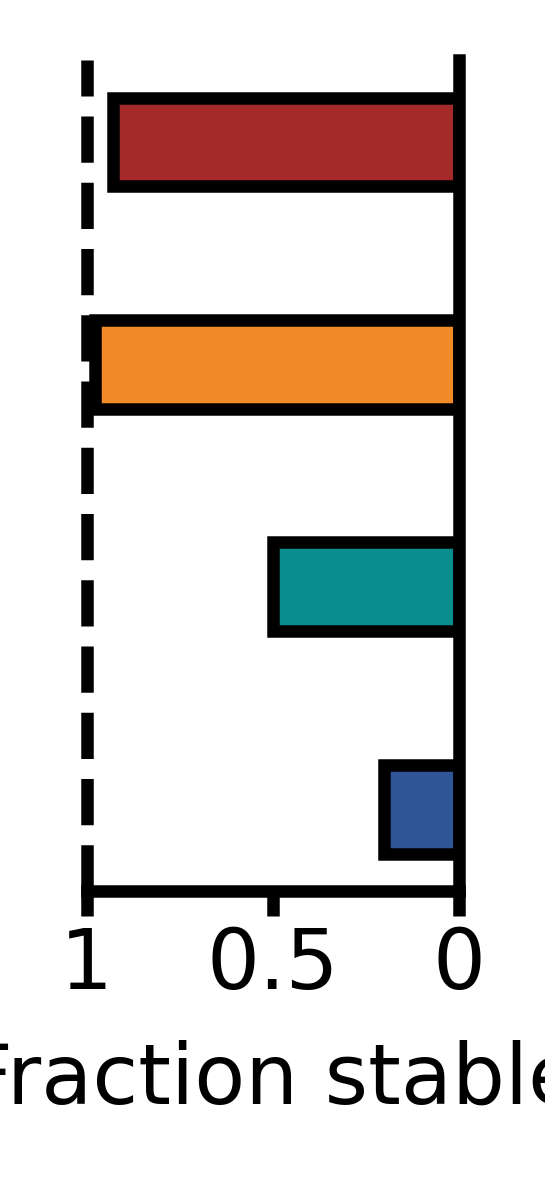

In [53]:
frac_ee = num_stable_ee/2500
frac_ei = num_stable_ei/2500
frac_ie = num_stable_ie/2500
frac_ii = num_stable_ii/2500
frac_ctrl = num_stable_ctrl/2500

axwidth = 1.5; fontsize = 10; dpi=600
labels = ['EE', 'EI', 'IE', 'II']
percentages_s = [frac_ii, frac_ie, frac_ei, frac_ee]

fig, ax = plt.subplots(figsize=(0.8, 1.8), dpi=dpi)
bars = ax.barh(labels, percentages_s, color=colors, edgecolor='black', linewidth=axwidth, height=0.4)
ax.axvline(x=1, color='black', linewidth=axwidth, linestyle='--', zorder=0.1, clip_on=False)
ax.invert_xaxis()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel('Fraction stable', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize, width=axwidth, length=axwidth*2, pad=1)
ax.tick_params(axis='y', labelsize=fontsize, width=axwidth, length=axwidth*2, pad=0)
ax.set_xlim(1, 0)  # Adjust the x-axis limits
ax.set_xticks([1, 0.5, 0])  # Adjust the x-axis tick positions
ax.set_xticklabels([1, 0.5, 0], fontsize=fontsize)
ax.set_yticks([])
ax.spines['bottom'].set_linewidth(axwidth)
ax.spines['right'].set_linewidth(axwidth)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Swapping terms in stable plasticity rules (Fig4.E&F)

#### Hebbian swap example

In [54]:
seed_orig = '2426ff02eaf3fee3e24de816474a8c74'
seed_swapped = 'd46e283626a803571b62c07fedf2b00c'

sts_orig = np.load("../data/296_goodandswaps_200325_" + seed_orig + ".npy", allow_pickle=True).item()
weights_orig = np.load("../data/296_goodandswaps_200325_" + seed_orig + "_weights.npy", allow_pickle=True).item()

sts_swapped = np.load("../data/296_goodandswaps_200325_" + seed_swapped + ".npy", allow_pickle=True).item()
weights_swapped = np.load("../data/296_goodandswaps_200325_" + seed_swapped + "_weights.npy", allow_pickle=True).item()

retrieved 296/296 simulations
291 / 296 rules fulfill the rate condition 98.3108108108108 %
282 / 296 rules fulfill the cv condition 95.27027027027027 %
261 / 296 rules fulfill the wf condition 88.17567567567568 %
263 / 296 rules fulfill the w_blow condition 88.85135135135135 %
247 / 296 rules fulfill all conditions 83.44594594594594 %

Original rule, seed 2426ff02eaf3fee3e24de816474a8c74 stable? True


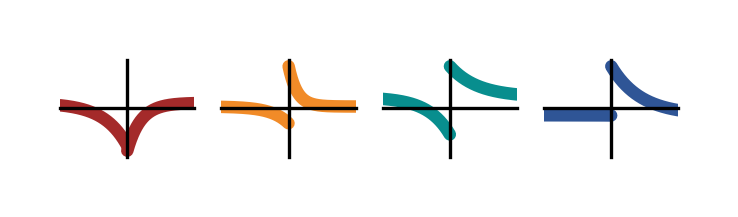

Swapped rule, seed d46e283626a803571b62c07fedf2b00c stable? False


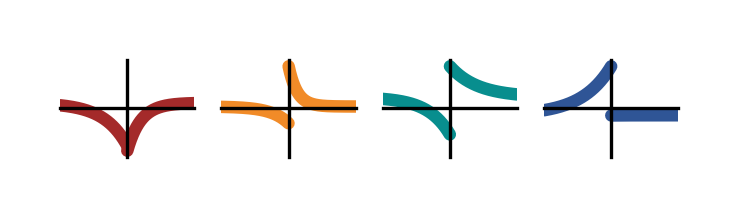

the two rules have the II rule swapped in time


In [55]:
# plot the two rules
bnd = aux.load_and_merge("../data/",("296_goodandswaps_200325_metrics.npy",))
inds_stable = aux.get_ind_stable(bnd)

ind_orig = np.where(bnd['seed'] == seed_orig)[0][0]
print("\nOriginal rule, seed", seed_orig, "stable?", inds_stable[ind_orig])
aux.plot_4_rules(bnd['theta'][ind_orig], linewidth=1.5, axwidth=0.4,figsize=(1.33,0.21))

ind_swapped = np.where(bnd['seed'] == seed_swapped)[0][0]
print("Swapped rule, seed", seed_swapped, "stable?", inds_stable[ind_swapped])
aux.plot_4_rules(bnd['theta'][ind_swapped], linewidth=1.5, axwidth=0.4,figsize=(1.33,0.21))
print("the two rules have the II rule swapped in time")

raster plot original rule after 4h


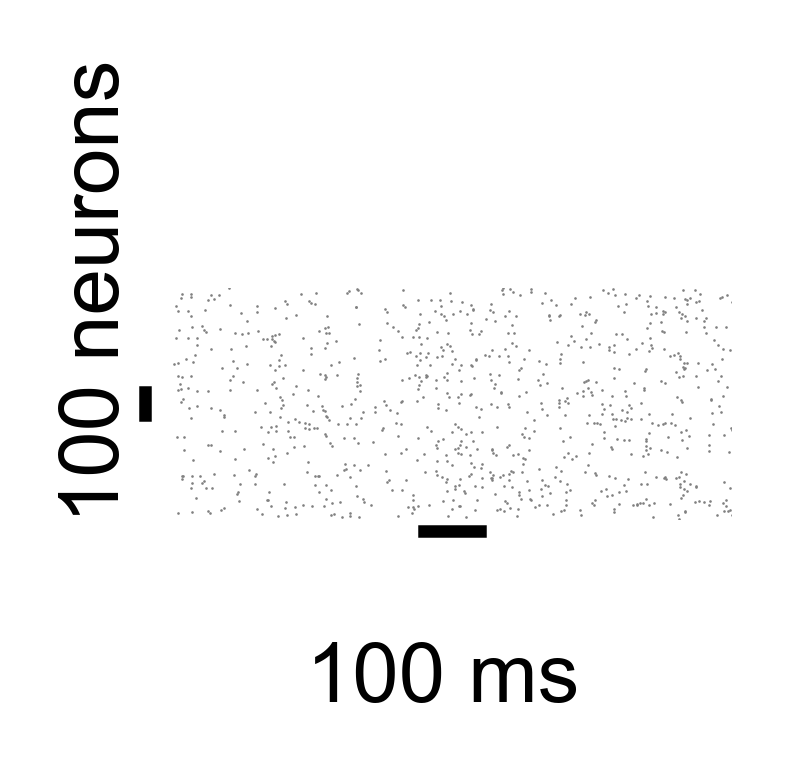

raster plot swapped rule after 4h


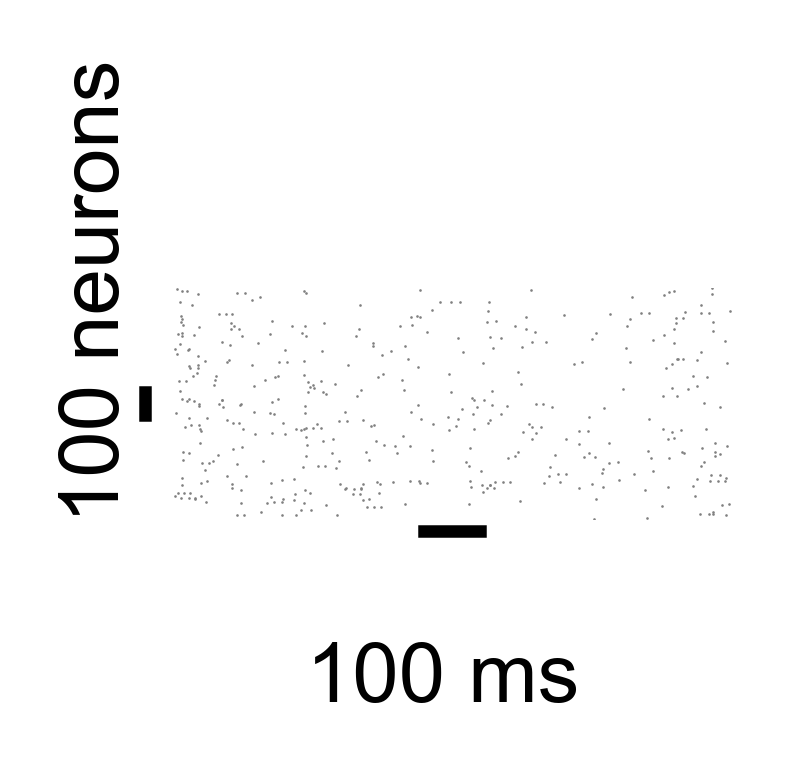

In [56]:
# plot the activity of the two rules
l_pretrain = 30
l_train = 10
duration_1test = 8
t_start_tests = np.array([1, 10,  20, 60, 120,  300, 600, 1200,  3600, 14400]) + l_pretrain + l_train
t_start_tests = [t_start_tests[i] + i*duration_1test for i in range(len(t_start_tests))]

print('raster plot original rule after 4h')
test_num = 9
aux.plot_raster(sts_orig,
    [i+2000 for i in range(700)],
    t_lim=[t_start_tests[test_num]-1,t_start_tests[test_num]],
    x_ticks=[],
    x_milestones=[],
    fontsize=10,
    color='gray',
    x_label='100 ms',
    y_label='100 neurons',
    markersize=0.1, 
    figsize=(1.2, 0.5),
    x_ticklabels=[],
    y_ticks=[],
    y_ticklabels=None,
    tickwidth=1.5,
    axwidth=1.5,
    dpi=600,
    ylabel_xloc=0.02,
    ylabel_yloc=0.15,
    xlabel_xloc=0.5,
    xlabel_yloc=-0.5,
    alpha_milestone=1,
    linewidth_milestones=1.5,
    zorder_milestone=1);plt.show()

print('raster plot swapped rule after 4h')
test_num = 9
aux.plot_raster(sts_swapped,
    [i+2000 for i in range(700)],
    t_lim=[t_start_tests[test_num]-1,t_start_tests[test_num]],
    x_ticks=[],
    x_milestones=[],
    fontsize=10,
    color='gray',
    x_label='100 ms',
    y_label='100 neurons',
    markersize=0.1, 
    figsize=(1.2, 0.5),
    x_ticklabels=[],
    y_ticks=[],
    y_ticklabels=None,
    tickwidth=1.5,
    axwidth=1.5,
    dpi=600,
    ylabel_xloc=0.02,
    ylabel_yloc=0.15,
    xlabel_xloc=0.5,
    xlabel_yloc=-0.5,
    alpha_milestone=1,
    linewidth_milestones=1.5,
    zorder_milestone=1);plt.show()

weights evolution of original rule after 4h


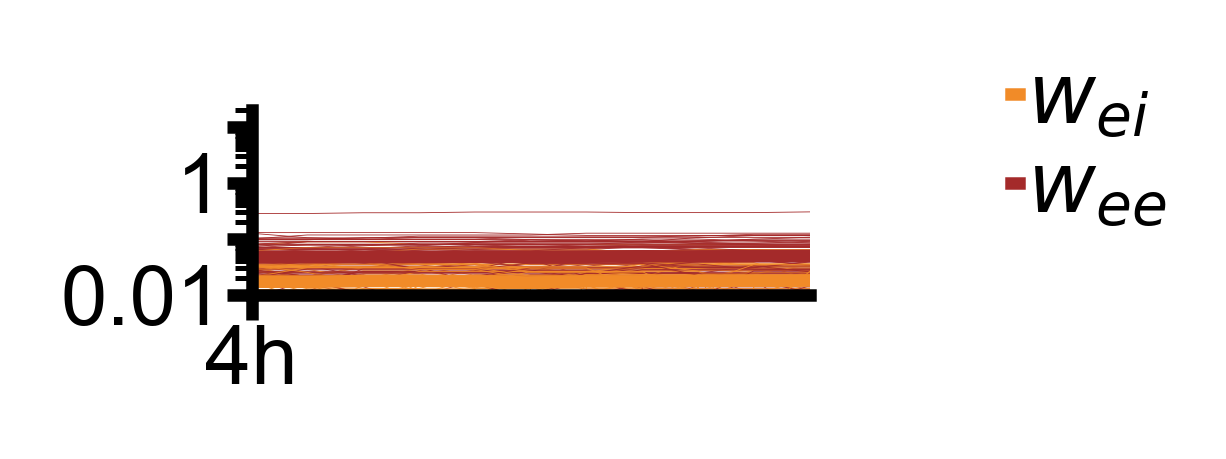

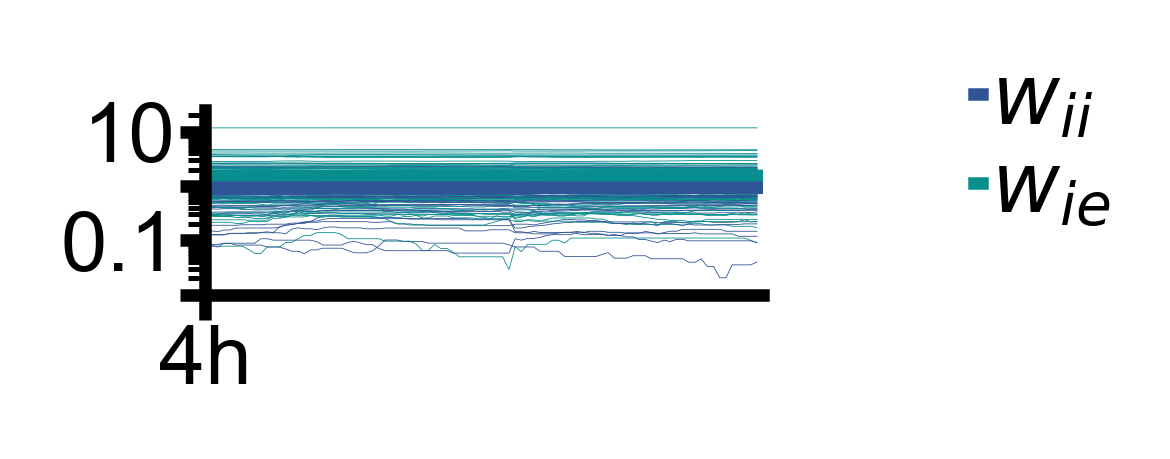

weights evolution of swapped rule after 4h


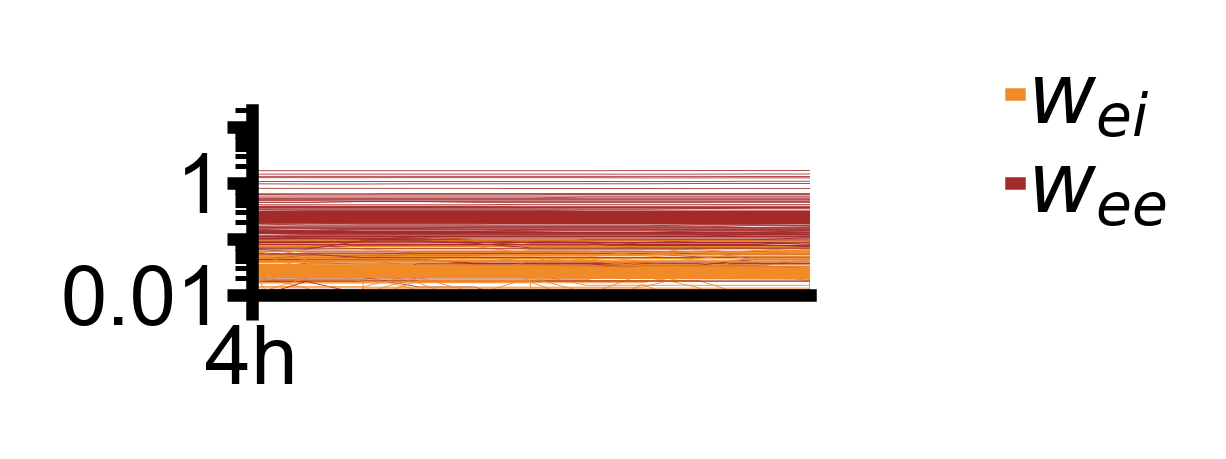

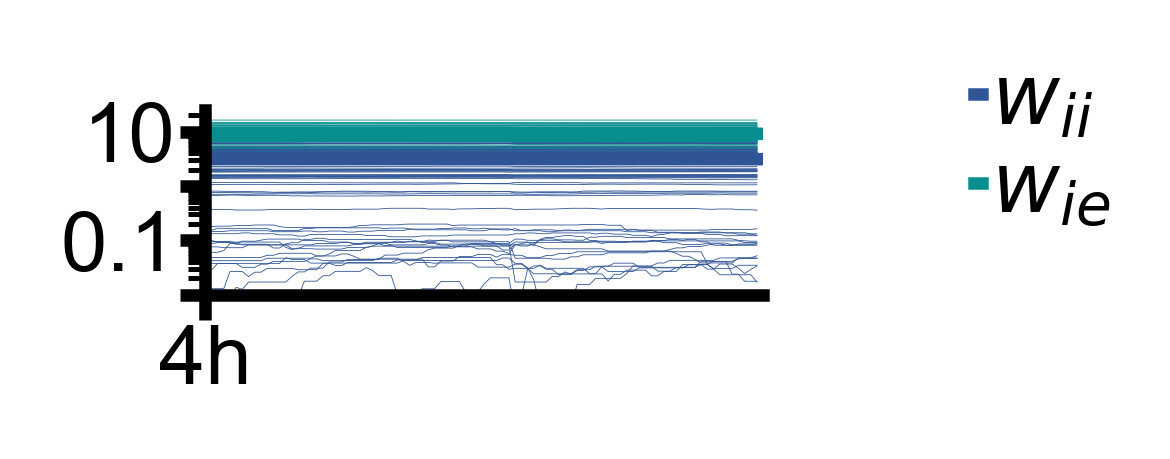

In [57]:
# plot the weight evolutions of the two rules
print('weights evolution of original rule after 4h')
aux.plot_weights(w1=weights_orig['ee'], w2=weights_orig['ei'], ts=weights_orig['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num],
             y_ticks=[0.01,0.1,1,10], y_ticklabels=[0.01,'',1,''], y_lim=[0.01,20],
             label1 = r'$w_{ee}$', label2 = r'$w_{ei}$',
             color1=aux.color_ee, color2=aux.color_ei, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2,0.4),)

aux.plot_weights(w1=weights_orig['ie'], w2=weights_orig['ii'], ts=weights_orig['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num]+duration_1test,
             y_ticks=[0.01,0.1,1,10], y_ticklabels=['',0.1,'',10], y_lim=[0.01,25],
             label1 = r'$w_{ie}$', label2 = r'$w_{ii}$',
             color1=aux.color_ie, color2=aux.color_ii, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2, 0.4),)

print('weights evolution of swapped rule after 4h')
aux.plot_weights(w1=weights_swapped['ee'], w2=weights_swapped['ei'], ts=weights_swapped['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num],
             y_ticks=[0.01,0.1,1,10], y_ticklabels=[0.01,'',1,''], y_lim=[0.01,20],
             label1 = r'$w_{ee}$', label2 = r'$w_{ei}$',
             color1=aux.color_ee, color2=aux.color_ei, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2,0.4),)

aux.plot_weights(w1=weights_swapped['ie'], w2=weights_swapped['ii'], ts=weights_swapped['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num]+duration_1test,
             y_ticks=[0.01,0.1,1,10], y_ticklabels=['',0.1,'',10], y_lim=[0.01,25],
             label1 = r'$w_{ie}$', label2 = r'$w_{ii}$',
             color1=aux.color_ie, color2=aux.color_ii, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2, 0.4),)

#### Non-Hebbian swap example

In [58]:
seed_orig = 'f19bec85c2d4104a767b4b821891852d'
seed_swapped = 'b4ac5088b7994c5eb156d0df20a77a01'

sts_orig = np.load("../data/296_goodandswaps_200325_" + seed_orig + ".npy", allow_pickle=True).item()
weights_orig = np.load("../data/296_goodandswaps_200325_" + seed_orig + "_weights.npy", allow_pickle=True).item()

sts_swapped = np.load("../data/296_goodandswaps_200325_" + seed_swapped + ".npy", allow_pickle=True).item()
weights_swapped = np.load("../data/296_goodandswaps_200325_" + seed_swapped + "_weights.npy", allow_pickle=True).item()

retrieved 296/296 simulations
291 / 296 rules fulfill the rate condition 98.3108108108108 %
282 / 296 rules fulfill the cv condition 95.27027027027027 %
261 / 296 rules fulfill the wf condition 88.17567567567568 %
263 / 296 rules fulfill the w_blow condition 88.85135135135135 %
247 / 296 rules fulfill all conditions 83.44594594594594 %

Original rule, seed f19bec85c2d4104a767b4b821891852d stable? True


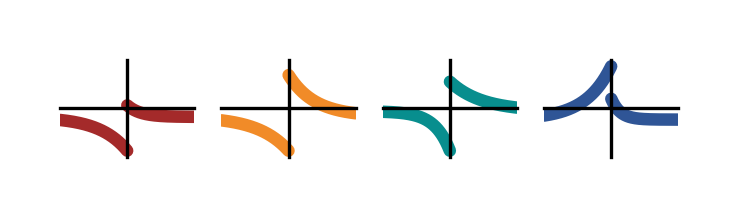

Swapped rule, seed b4ac5088b7994c5eb156d0df20a77a01 stable? False


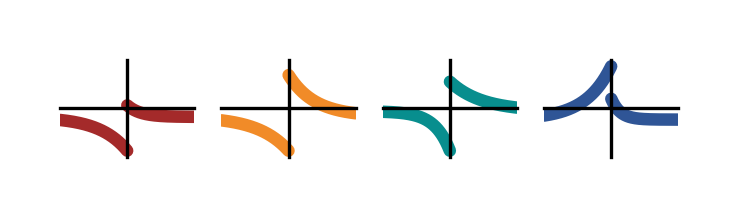

the two rules look the same according to the stdp protocol


In [59]:
# plot the two rules
bnd = aux.load_and_merge("../data/",("296_goodandswaps_200325_metrics.npy",))
inds_stable = aux.get_ind_stable(bnd)

ind_orig = np.where(bnd['seed'] == seed_orig)[0][0]
print("\nOriginal rule, seed", seed_orig, "stable?", inds_stable[ind_orig])
aux.plot_4_rules(bnd['theta'][ind_orig], linewidth=1.5, axwidth=0.4,figsize=(1.33,0.21))

ind_swapped = np.where(bnd['seed'] == seed_swapped)[0][0]
print("Swapped rule, seed", seed_swapped, "stable?", inds_stable[ind_swapped])
aux.plot_4_rules(bnd['theta'][ind_swapped], linewidth=1.5, axwidth=0.4,figsize=(1.33,0.21))
print("the two rules look the same according to the stdp protocol")

raster plot original rule after 4h


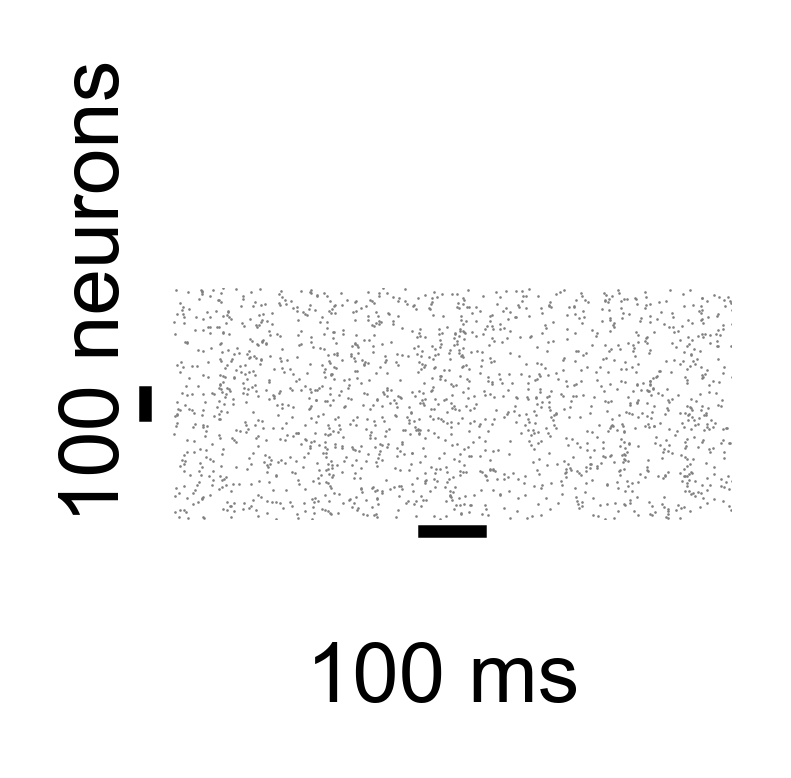

raster plot swapped rule after 4h


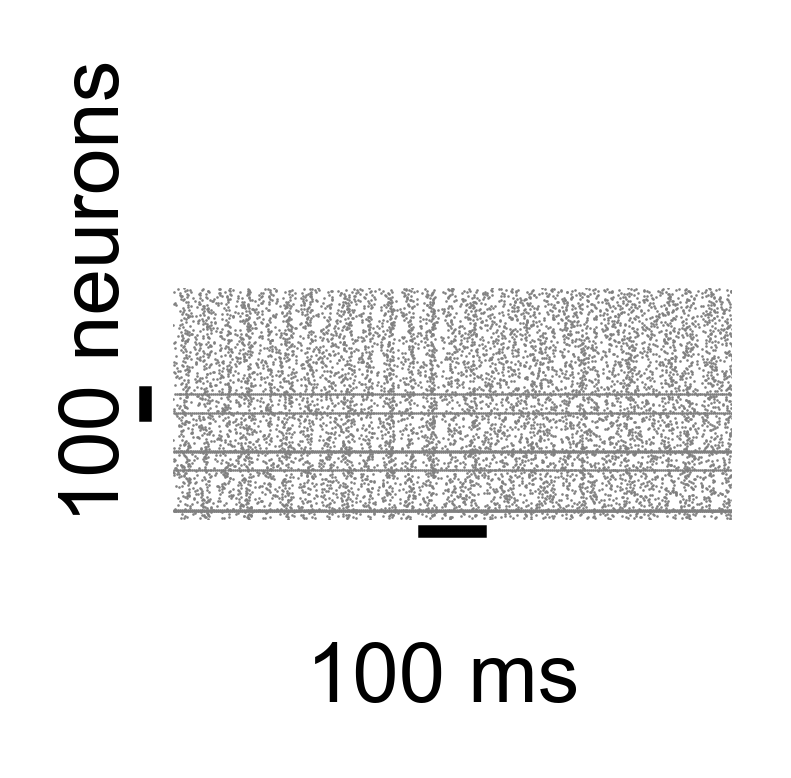

In [60]:
# plot the activity of the two rules
l_pretrain = 30
l_train = 10
duration_1test = 8
t_start_tests = np.array([1, 10,  20, 60, 120,  300, 600, 1200,  3600, 14400]) + l_pretrain + l_train
t_start_tests = [t_start_tests[i] + i*duration_1test for i in range(len(t_start_tests))]

print('raster plot original rule after 4h')
test_num = 9
aux.plot_raster(sts_orig,
    [i+2000 for i in range(700)],
    t_lim=[t_start_tests[test_num]-1,t_start_tests[test_num]],
    x_ticks=[],
    x_milestones=[],
    fontsize=10,
    color='gray',
    x_label='100 ms',
    y_label='100 neurons',
    markersize=0.1, 
    figsize=(1.2, 0.5),
    x_ticklabels=[],
    y_ticks=[],
    y_ticklabels=None,
    tickwidth=1.5,
    axwidth=1.5,
    dpi=600,
    ylabel_xloc=0.02,
    ylabel_yloc=0.15,
    xlabel_xloc=0.5,
    xlabel_yloc=-0.5,
    alpha_milestone=1,
    linewidth_milestones=1.5,
    zorder_milestone=1);plt.show()

print('raster plot swapped rule after 4h')
test_num = 9
aux.plot_raster(sts_swapped,
    [i+2000 for i in range(700)],
    t_lim=[t_start_tests[test_num]-1,t_start_tests[test_num]],
    x_ticks=[],
    x_milestones=[],
    fontsize=10,
    color='gray',
    x_label='100 ms',
    y_label='100 neurons',
    markersize=0.1, 
    figsize=(1.2, 0.5),
    x_ticklabels=[],
    y_ticks=[],
    y_ticklabels=None,
    tickwidth=1.5,
    axwidth=1.5,
    dpi=600,
    ylabel_xloc=0.02,
    ylabel_yloc=0.15,
    xlabel_xloc=0.5,
    xlabel_yloc=-0.5,
    alpha_milestone=1,
    linewidth_milestones=1.5,
    zorder_milestone=1);plt.show()

weights evolution of original rule after 4h


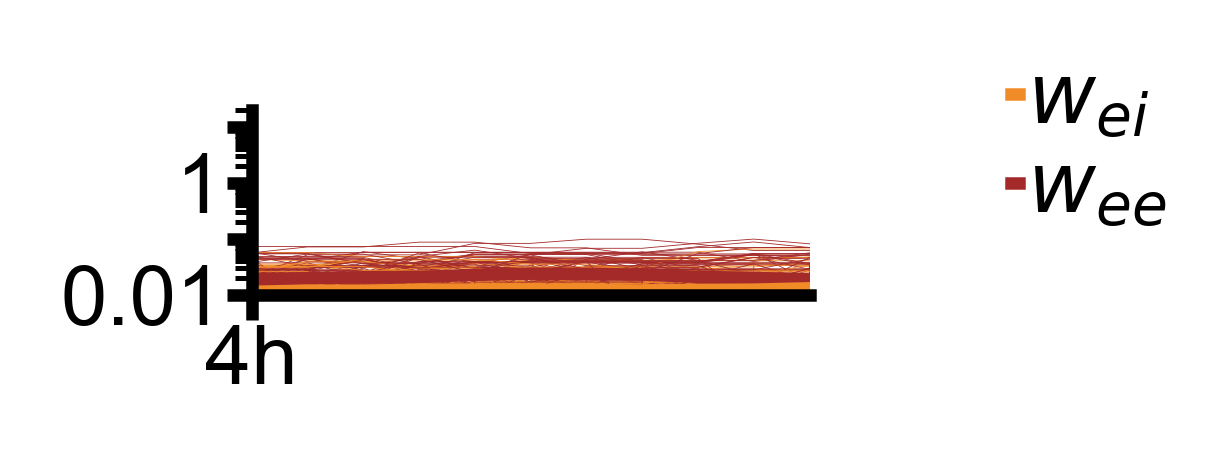

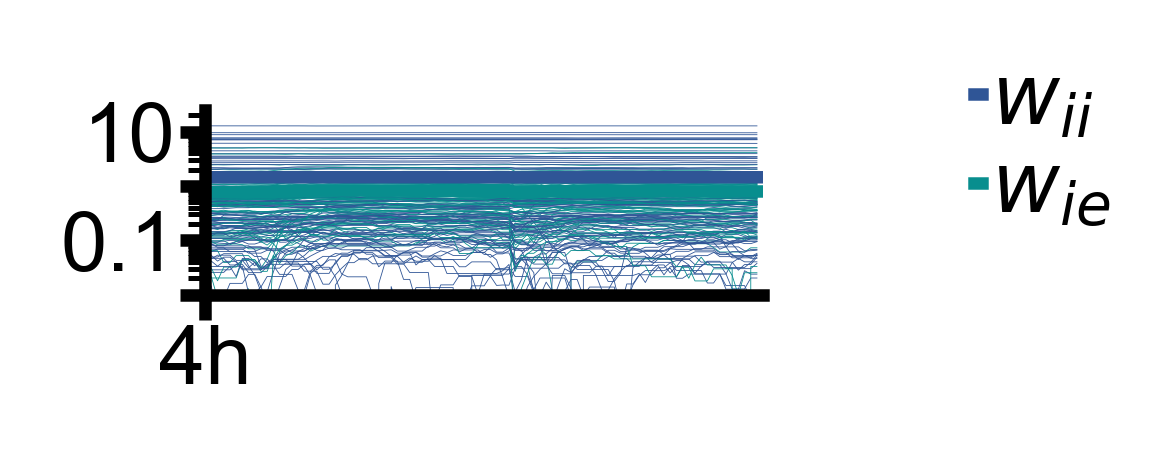

weights evolution of swapped rule after 4h


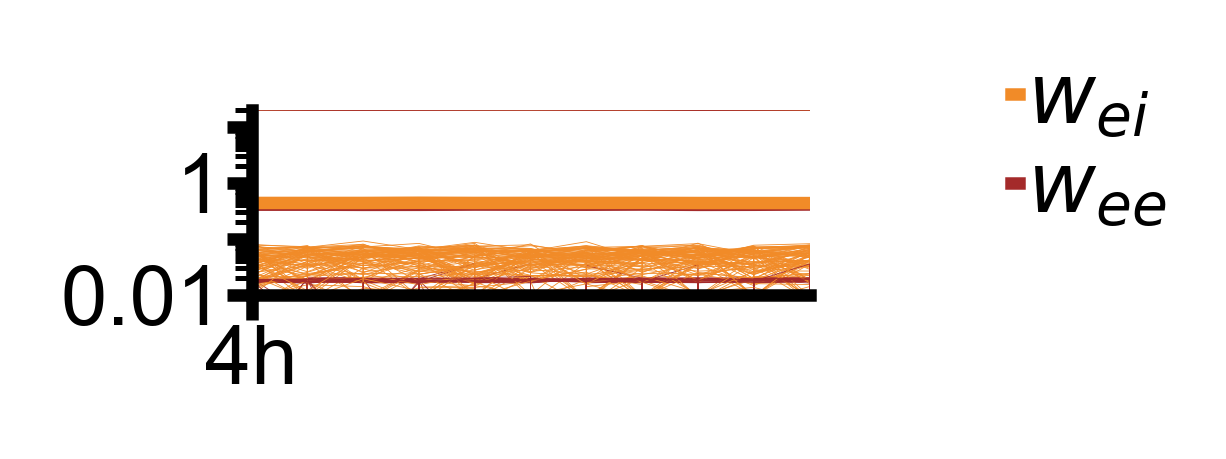

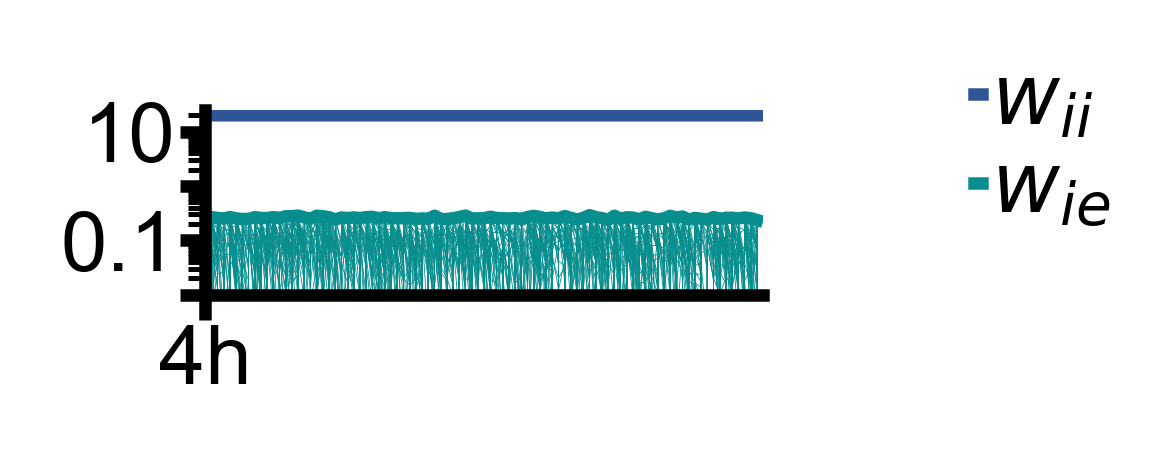

In [61]:
# plot the weight evolutions of the two rules
print('weights evolution of original rule after 4h')
aux.plot_weights(w1=weights_orig['ee'], w2=weights_orig['ei'], ts=weights_orig['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num],
             y_ticks=[0.01,0.1,1,10], y_ticklabels=[0.01,'',1,''], y_lim=[0.01,20],
             label1 = r'$w_{ee}$', label2 = r'$w_{ei}$',
             color1=aux.color_ee, color2=aux.color_ei, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2,0.4),)

aux.plot_weights(w1=weights_orig['ie'], w2=weights_orig['ii'], ts=weights_orig['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num]+duration_1test,
             y_ticks=[0.01,0.1,1,10], y_ticklabels=['',0.1,'',10], y_lim=[0.01,25],
             label1 = r'$w_{ie}$', label2 = r'$w_{ii}$',
             color1=aux.color_ie, color2=aux.color_ii, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2, 0.4),)

print('weights evolution of swapped rule after 4h')
aux.plot_weights(w1=weights_swapped['ee'], w2=weights_swapped['ei'], ts=weights_swapped['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num],
             y_ticks=[0.01,0.1,1,10], y_ticklabels=[0.01,'',1,''], y_lim=[0.01,20],
             label1 = r'$w_{ee}$', label2 = r'$w_{ei}$',
             color1=aux.color_ee, color2=aux.color_ei, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2,0.4),)

aux.plot_weights(w1=weights_swapped['ie'], w2=weights_swapped['ii'], ts=weights_swapped['t'], 
             t_start=t_start_tests[test_num]-1, t_stop=t_start_tests[test_num]+duration_1test,
             y_ticks=[0.01,0.1,1,10], y_ticklabels=['',0.1,'',10], y_lim=[0.01,25],
             label1 = r'$w_{ie}$', label2 = r'$w_{ii}$',
             color1=aux.color_ie, color2=aux.color_ii, 
             linewidth_weights=0.1,
             x_milestones=[],
             x_ticks=[t_start_tests[test_num]-1],
             x_ticklabels=['4h'],
             ylog = True,
             figsize=(1.2, 0.4),)

### Robustness analysis (Fig4.G)

In [ ]:
# Load the simulations with the perturbations on active input rate, initial weights, initialization and background input rate
# Then compute their delta r mem
save_dir = "../data/"
data_rinp_low = aux.load_and_merge(save_dir,("2500_1s4hBreaks_rinp5Hz_26092024_metrics.npy",))
dr_rinp_low = np.array(2*(data_rinp_low['r_nov'] - data_rinp_low['r_fam']) / (data_rinp_low['r_nov'] + data_rinp_low['r_fam']+0.01))

data_rinp_high = aux.load_and_merge(save_dir,("2500_1s4hBreaks_rinp15Hz_26092024_metrics.npy",))
dr_rinp_high = np.array(2*(data_rinp_high['r_nov'] - data_rinp_high['r_fam']) / (data_rinp_high['r_nov'] + data_rinp_high['r_fam']+0.01))

data_wpert = aux.load_and_merge(save_dir,("2500_1s4hBreaks_we0p05wi2_24022025_metrics.npy",))
dr_wpert = 2*(data_wpert['r_nov'] - data_wpert['r_fam']) / (data_wpert['r_nov'] + data_wpert['r_fam']+0.01)

data_ract = aux.load_and_merge(save_dir,("2500_1s4hBreaks_ract90_19022025_metrics.npy",))
dr_ract = 2*(data_ract['r_nov'] - data_ract['r_fam']) / (data_ract['r_nov'] + data_ract['r_fam']+0.01)

data_seed1 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_17092024_metrics.npy",))
dr_seed1 = 2*(data_seed1['r_nov'] - data_seed1['r_fam']) / (data_seed1['r_nov'] + data_seed1['r_fam']+0.01)

data_seed2 = aux.load_and_merge(save_dir,("2500_1s4hBreaks_24092024_metrics.npy",))
dr_seed2 = 2*(data_seed2['r_nov'] - data_seed2['r_fam']) / (data_seed2['r_nov'] + data_seed2['r_fam']+0.01)

retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations
retrieved 2500/2500 simulations


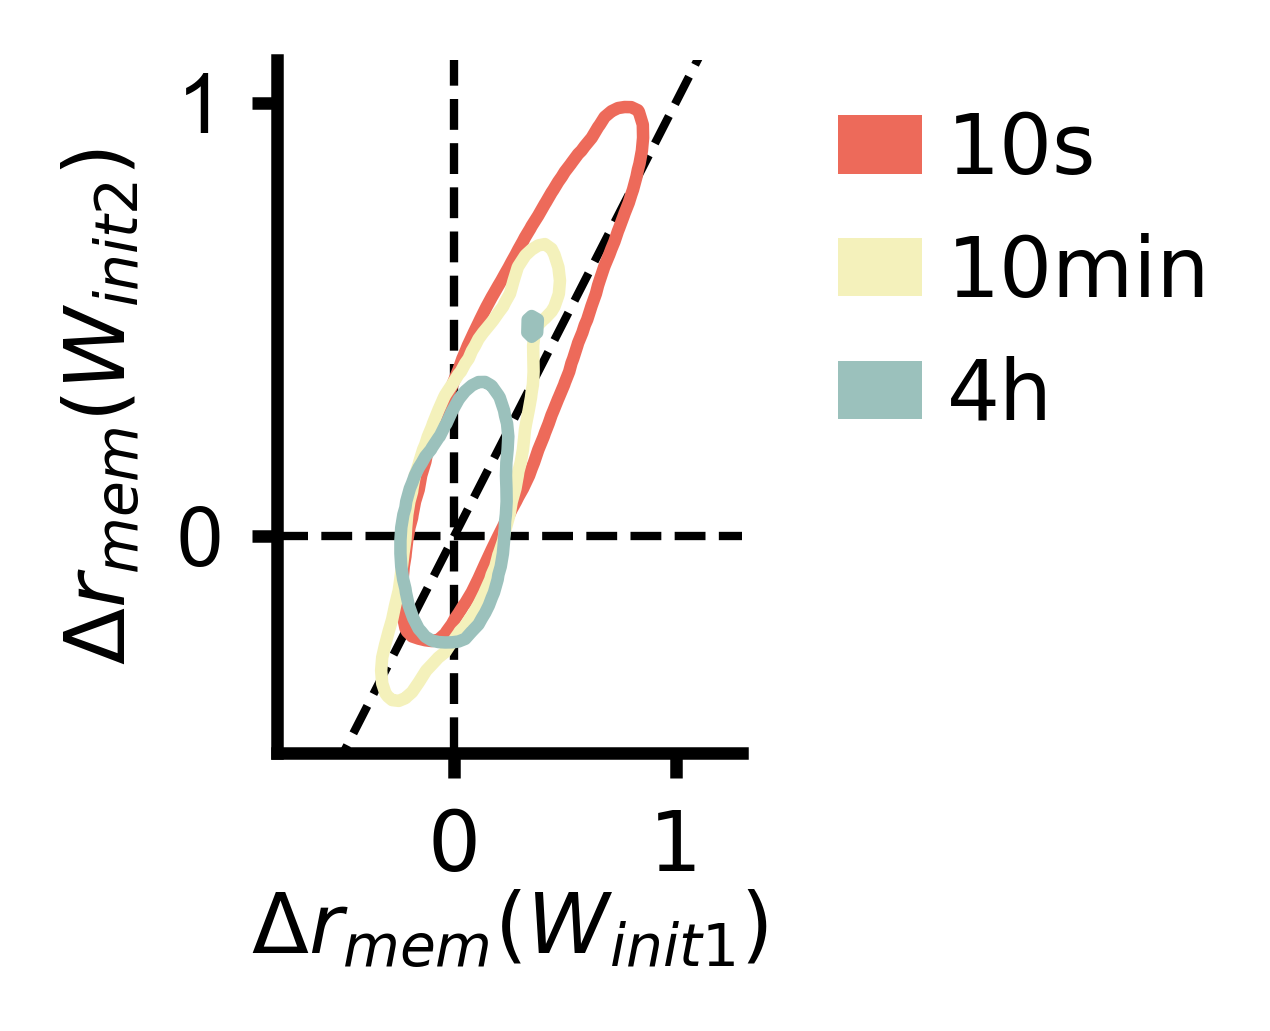

In [63]:
# changing the active firing rate
colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']  
timepoints_to_plot = [1,5,9]
aux.plot_2Dhist_contour([dr_seed1[:,t] for t in timepoints_to_plot],
            [dr_ract[:,t] for t in timepoints_to_plot],
            xlabel=r'$\Delta r_{mem}(W_{init1})$',
            ylabel=r'$\Delta r_{mem}(W_{init2})$',
            xlim=[-0.8,1.3],
            xticks=[0,1],
            ylim=[-0.5,1.1],
            yticks=[0,1],
            linewidth_line=1,
            alpha_line=1,
            colors=colors,
            figsize=(1,1.5),
            center_axes=False,
            linewidth=1.5,
            level=0.1,
            gaussian_filt_sigma=1.8,
            labels_data=["10s","10min","4h"],
            xhandlepad=0,
            range_2Dhist=[[-1, 2], [-1, 2]],
            bbox_to_anchor=(1.1, 1))

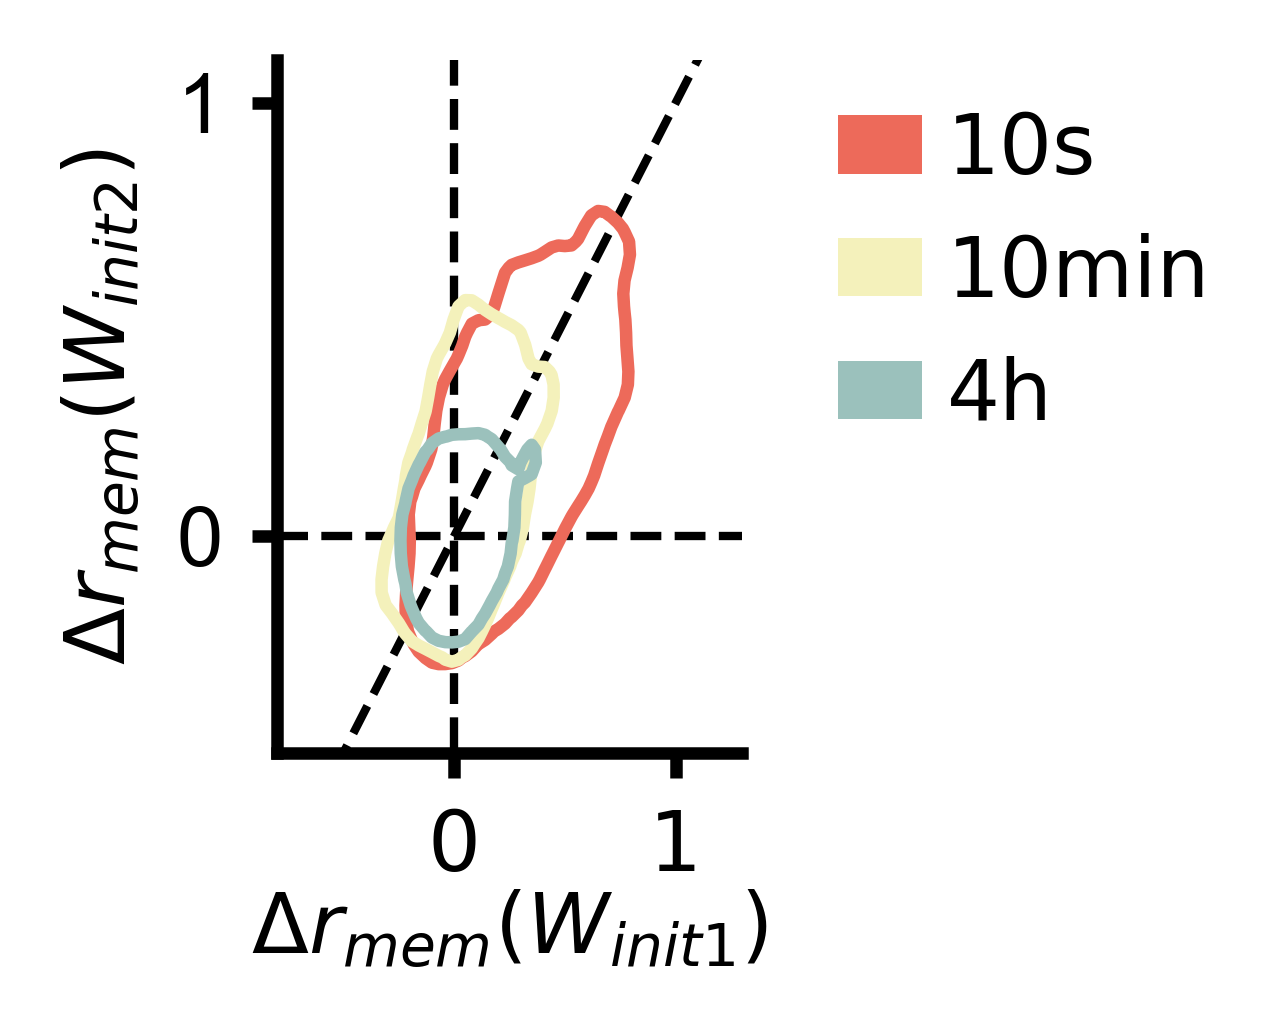

In [64]:
# changing the weight initialization (mean of the distributions)
colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']  
timepoints_to_plot = [1,5,9]
aux.plot_2Dhist_contour([dr_seed1[:,t] for t in timepoints_to_plot],
            [dr_wpert[:,t] for t in timepoints_to_plot],
            xlabel=r'$\Delta r_{mem}(W_{init1})$',
            ylabel=r'$\Delta r_{mem}(W_{init2})$',
            xlim=[-0.8,1.3],
            xticks=[0,1],
            ylim=[-0.5,1.1],
            yticks=[0,1],
            linewidth_line=1,
            alpha_line=1,
            colors=colors,
            figsize=(1,1.5),
            center_axes=False,
            linewidth=1.5,
            level=0.1,
            gaussian_filt_sigma=1.8,
            labels_data=["10s","10min","4h"],
            xhandlepad=0,
            range_2Dhist=[[-1, 2], [-1, 2]],
            bbox_to_anchor=(1.1, 1))

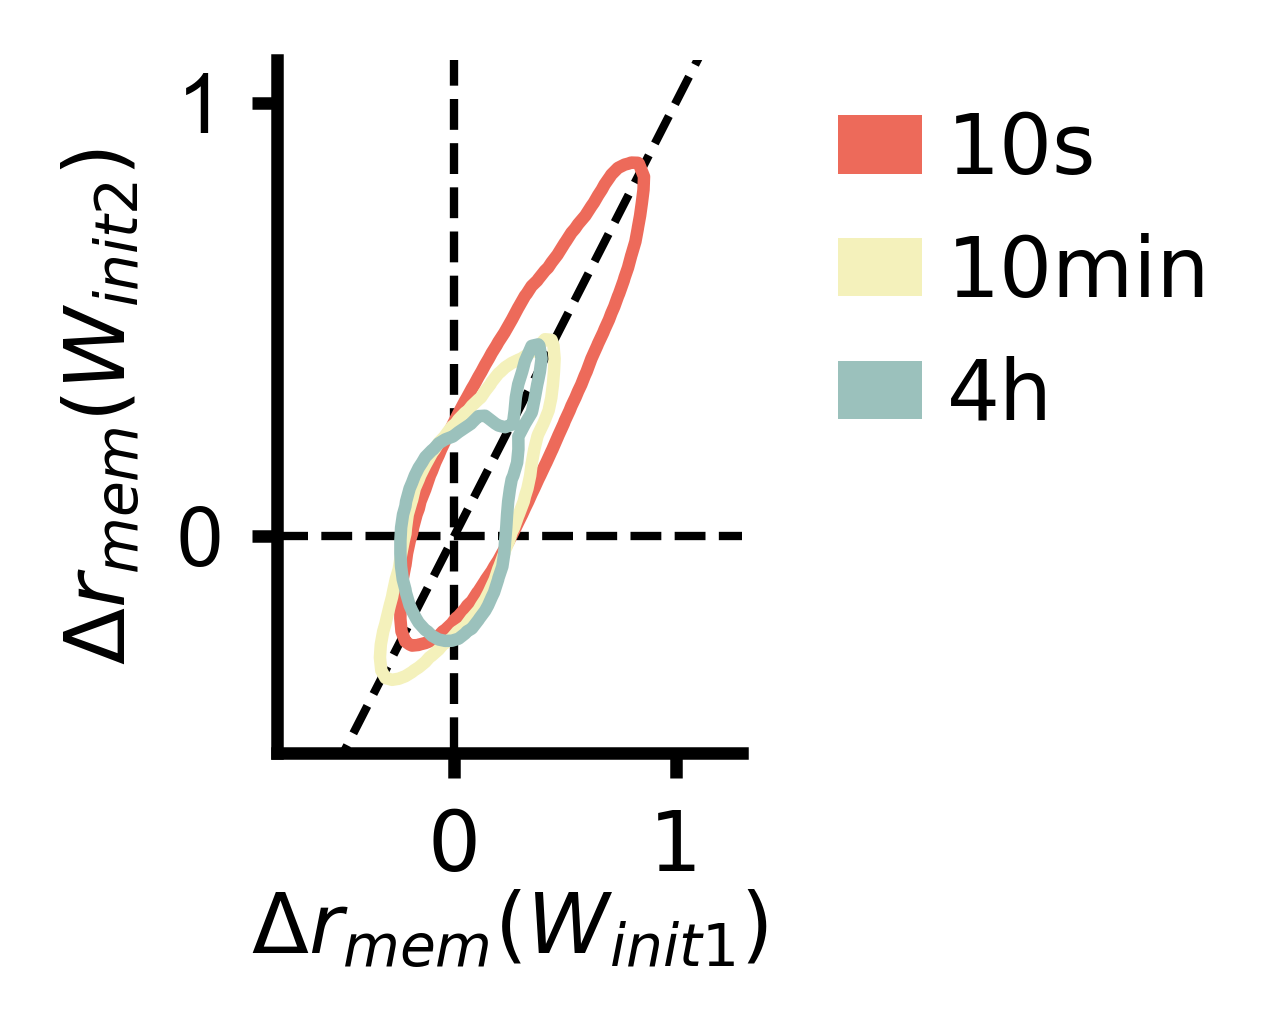

In [65]:
# changing the weight initialization (seed)
colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']  
timepoints_to_plot = [1,5,9]
aux.plot_2Dhist_contour([dr_seed1[:,t] for t in timepoints_to_plot],
            [dr_seed2[:,t] for t in timepoints_to_plot],
            xlabel=r'$\Delta r_{mem}(W_{init1})$',
            ylabel=r'$\Delta r_{mem}(W_{init2})$',
            xlim=[-0.8,1.3],
            xticks=[0,1],
            ylim=[-0.5,1.1],
            yticks=[0,1],
            linewidth_line=1,
            alpha_line=1,
            colors=colors,
            figsize=(1,1.5),
            center_axes=False,
            linewidth=1.5,
            level=0.1,
            gaussian_filt_sigma=1.8,
            labels_data=["10s","10min","4h"],
            xhandlepad=0,
            range_2Dhist=[[-1, 2], [-1, 2]],
            bbox_to_anchor=(1.1, 1))

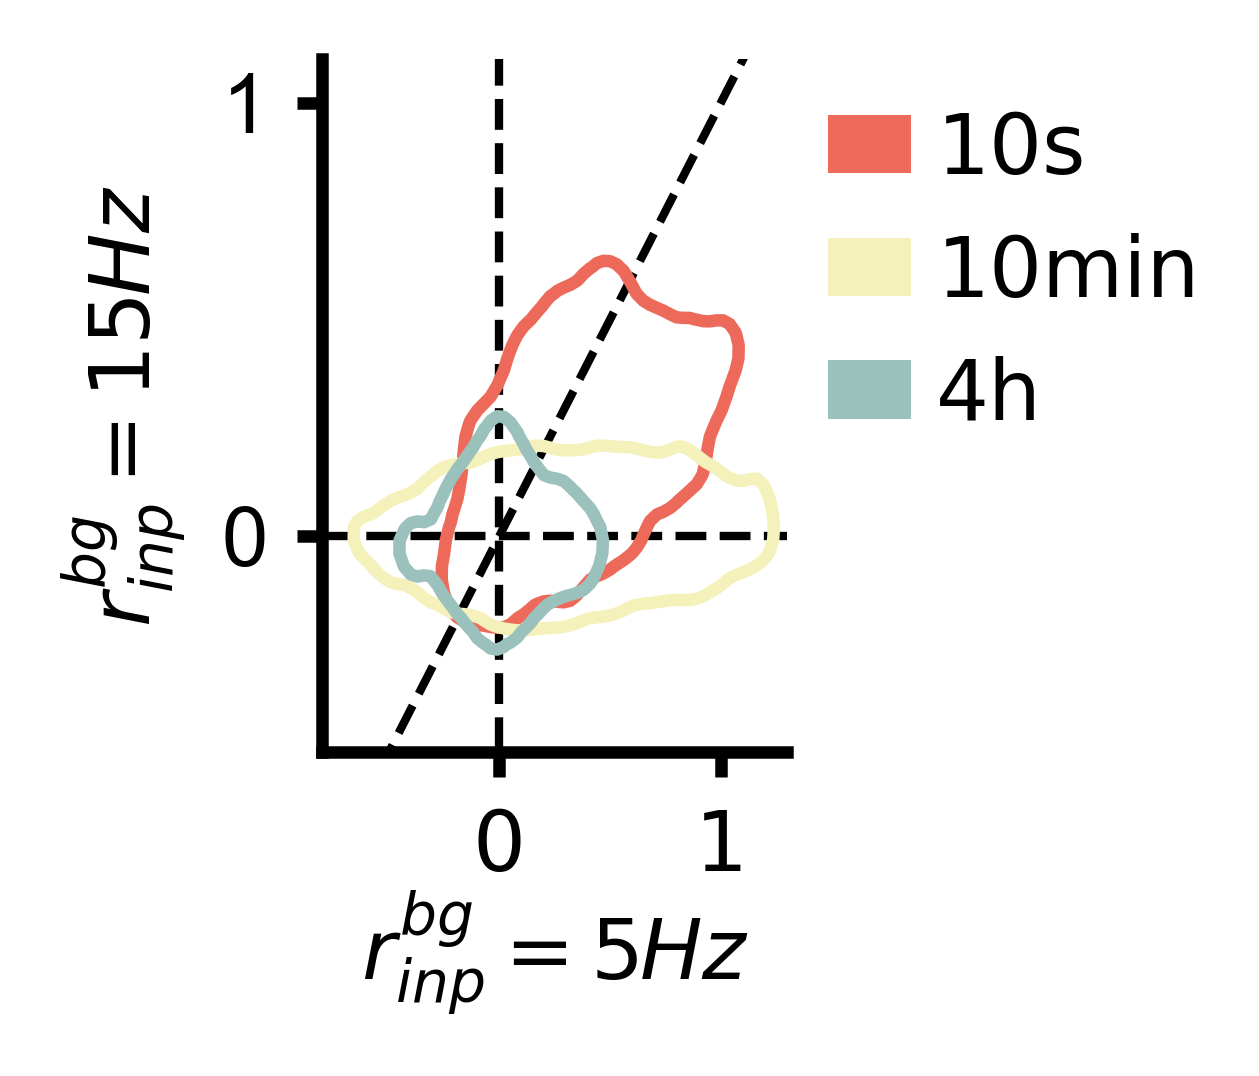

In [66]:
# changing the background input rate
colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']  
timepoints_to_plot = [1,5,9]
aux.plot_2Dhist_contour([dr_rinp_low[:,t] for t in timepoints_to_plot],
            [dr_rinp_high[:,t] for t in timepoints_to_plot],
            xlabel=r'$r_{inp}^{bg}=5Hz$',
            ylabel=r'$r_{inp}^{bg}=15Hz$',
            xlim=[-0.8,1.3],
            xticks=[0,1],
            ylim=[-0.5,1.1],
            yticks=[0,1],
            linewidth_line=1,
            alpha_line=1,
            colors=colors,
            figsize=(1,1.5),
            center_axes=False,
            linewidth=1.5,
            level=0.1,
            gaussian_filt_sigma=1.8,
            labels_data=["10s","10min","4h"],
            xhandlepad=0,
            range_2Dhist=[[-1, 2], [-1, 2]],
            bbox_to_anchor=(0.98, 1))